# Group 5 Project

In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
%matplotlib inline
from datetime import datetime as dt
from matplotlib.pylab import date2num
import time
from pandas.core.frame import DataFrame
from dateutil.parser import parse
import seaborn as sns
from sqlalchemy import create_engine
import time
from datetime import datetime
import json
import matplotlib.pyplot as plt
from IPython.display import Image

## Part 1 - Selection (30 points)

_Identify and describe your dataset, its source, and what appeals
to you about it.  Acquire the data and perform an initial exploration
to determine which themes you wish to explore.  Describe the questions
you want to be able to answer with the data, any concerns you have
about the data, and any challenges you expect to have to overcome._

### 1. Data Preparation and Overview 
__DATA SOURCE:__ https://www.kaggle.com/chicago/chicago-taxi-rides-2016 

#### 1. Backgroud overview: Why we chose the dataset?

As traffic volumes continue to grow in the coming decades, the public sector will need to consider every possible opportunity to better manage all transportation systems and infrastructure. Better traffic flow is achievable in part with better systems for collecting and analyzing real-time traffic data. In this arena, transportation managers can learn from the technologies and practices deployed by private companies.       

Government can provide route optimization suggestions during rush hours. The in-time system combines daily data on package delivery commitments and historical route tracking to identify the optimal path. By diving into the data, knowing where people need to go, when people go, determining how to make the transportation system the best it can be, then investing in the needed technology to realize those improvements. 

#### 2 。Acquire the data and perform an initial exploration to determine which themes you wish to explore. 
 
With the development of sharing economy, shared cars, such as Uber, gradually become a new trend. In order to open a new market and save advertising expenses, Uber needs to do market analysis. Our group is to help Uber do research about Chicago market, including consumer behavior, economic environment and taxi industry. 
 
 
2、Describe the questions you want to be able to answer with the data, any concerns you have about the data, and any challenges you expect to have to overcome.
 
We want to know how the taxi is charged, which community people are usually picked up or dropped off, what the behavior of people is and etc.
 
The dataset is not the latest one, which could lead us to wrong conclusion. How to access to more consumer is the key in today’s business world.  We want to dig into the behavior of customer. For example, we can analyze whether the weather will influence the behavior of people who take taxi.


#### 2.Set up

In [2]:
%load_ext sql

In [3]:
!dropdb -U student project4
!createdb -U student project4

In [4]:
%sql postgresql://student@/project4

'Connected: student@project4'

#### 3. Upload the dataset
__what is the dataset?__ :This dataset includes taxi trips for 2016, reported to the City of Chicago in its role as a regulatory agency. Due to the data reporting process, not all trips are reported but the City believes that most are.

In [5]:
!wget https://s3.amazonaws.com/chicagotax/Chicago_Taxi.csv

--2018-12-10 16:56:03--  https://s3.amazonaws.com/chicagotax/Chicago_Taxi.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54280005 (52M) [text/csv]
Saving to: ‘Chicago_Taxi.csv’

Chicago_Taxi.csv    100%[===================>]  51.76M  36.2MB/s    in 1.4s    

2018-12-10 16:56:04 (36.2 MB/s) - ‘Chicago_Taxi.csv’ saved [54280005/54280005]



### 2.Explore the dataset

#### 1. Overview analysis

The number of records is 348841, the header included.

In [6]:
!wc -l Chicago_Taxi.csv

348841 Chicago_Taxi.csv


There are 19 columns in the dataset. 'trip_seconds','trip_miles','fare','tips','tolls','extras' and 'trip_total' are __facts__, others are __dimensions__.

In [7]:
!csvcut -n Chicago_Taxi.csv

  1: 
  2: taxi_id
  3: trip_start_timestamp
  4: Time
  5: trip_seconds
  6: trip_miles
  7: pickup_community_area
  8: dropoff_community_area
  9: fare
 10: tips
 11: tolls
 12: extras
 13: trip_total
 14: payment_type
 15: pickup_latitude
 16: pickup_longitude
 17: dropoff_latitude
 18: dropoff_longitude
 19: company


We had an overview of the dataset by _csvstat_. After clean the data step, the dataset is clean and contains no null, but there are problems about the data type such as the column 'trip_start_timestamp' which will be fixed using sql in the following steps.

In [8]:
!head -n 100 Chicago_Taxi.csv | csvstat

/home/ubuntu/.local/lib/python3.5/site-packages/agate/utils.py:276: UnnamedColumnWarning: Column 0 has no name. Using "a".
  1. "a"

	Type of data:          Number
	Contains null values:  False
	Unique values:         99
	Smallest value:        0
	Largest value:         98
	Sum:                   4,851
	Mean:                  49
	Median:                49
	StDev:                 28.723
	Most common values:    0 (1x)
	                       1 (1x)
	                       2 (1x)
	                       3 (1x)
	                       4 (1x)

  2. "taxi_id"

	Type of data:          Number
	Contains null values:  False
	Unique values:         99
	Smallest value:        27
	Largest value:         8,618
	Sum:                   407,570
	Mean:                  4,116.869
	Median:                4,284
	StDev:                 2,509.769
	Most common values:    85 (1x)
	                       6,641 (1x)
	                       6,078 (1x)
	                       221 (1x)
	                       5,367

we also drew a map to show how the pick up location distrbuted on tableau. It is very clear that there are many rides along  Lake Michigan.

In [9]:
!wget https://s3.amazonaws.com/chicagotax/map.png

--2018-12-10 16:56:05--  https://s3.amazonaws.com/chicagotax/map.png
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 997978 (975K) [image/png]
Saving to: ‘map.png’

map.png             100%[===================>] 974.59K  --.-KB/s    in 0.03s   

2018-12-10 16:56:06 (27.3 MB/s) - ‘map.png’ saved [997978/997978]



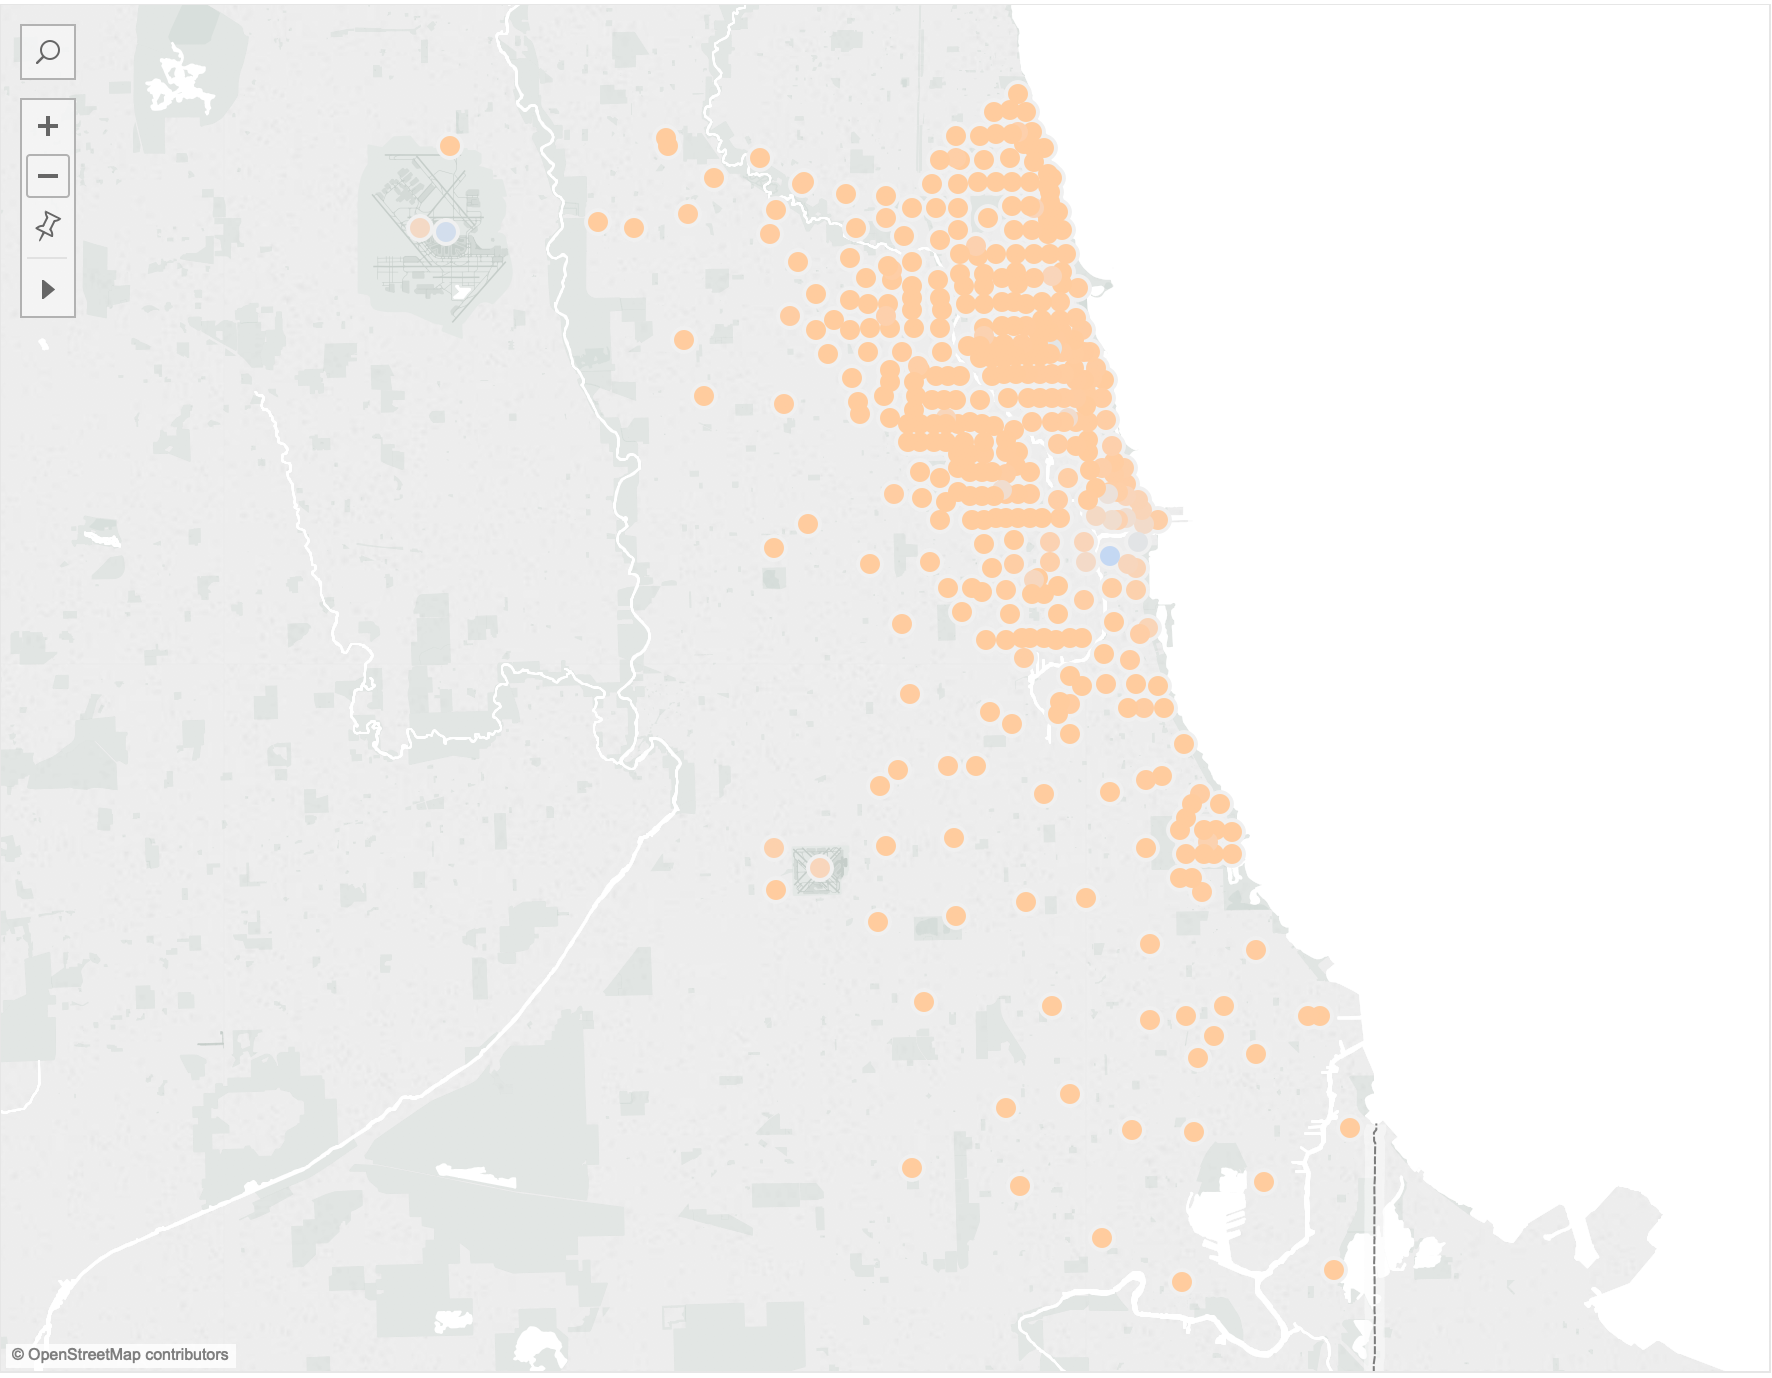

In [10]:
Image(filename = 'map.png', width = 800, height = 600)

In [11]:
!csvcut -n Chicago_Taxi.csv

  1: 
  2: taxi_id
  3: trip_start_timestamp
  4: Time
  5: trip_seconds
  6: trip_miles
  7: pickup_community_area
  8: dropoff_community_area
  9: fare
 10: tips
 11: tolls
 12: extras
 13: trip_total
 14: payment_type
 15: pickup_latitude
 16: pickup_longitude
 17: dropoff_latitude
 18: dropoff_longitude
 19: company


#### 2. More analysis unsing pipeline
#####  1. What is the most popular companies?

In [12]:
!csvcut -c19 Chicago_Taxi.csv|sort| uniq -c | sort -rn | head -10

 185894 Taxi Affiliation Services
  47844 Dispatch Taxi Affiliation
  38162 Blue Ribbon Taxi Association Inc.
  32967 Choice Taxi Association
  15121 Northwest Management LLC
  10819 KOAM Taxi Association
  10109 Top Cab Affiliation
   2006 Chicago Medallion Leasing INC
   1156 Chicago Elite Cab Corp. (Chicago Carriag
   1068 Chicago Medallion Management


##### 2.What is the longest trip-mile?

In [13]:
!csvcut -c5 Chicago_Taxi.csv|sort -r|head -3

trip_seconds
9900.0
9900.0
sort: write failed: 'standard output': Broken pipe
sort: write error


##### 3.what is the longest trip for Taxi Affiliation Services company?

In [14]:
!csvgrep -c19 -r "Taxi Affiliation Services" Chicago_Taxi.csv | csvcut -c6| sort -r | head

trip_miles
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
9.9
sort: write failed: 'standard output': Broken pipe
sort: write error


#### Questions raised
__Based on an overview understanding about our dataset, there are some questions we would love to explore.__
1. which time does the customers use taxies most?
2. Which area is the most popular for people to use taxi?
3. How is the taxi priced?
4. Which payment type does people usually prefer?
5. Difference between weekends and weekdays?
6. Relationship between time and pickup location?

## Part 2 - Wrangling (35 points)

_Based on what you found above, wrangle the data into a format
suitable for analysis.  This may involve cleaning, filtering,
merging, and modeling steps, any and all of which are valid for
this project.  Describe your process as you proceed, and document
any scripts, databases, or other models you develop.  Be specific
about any key decisions to modify or remove data, how you overcame
any challenges, and all assumptions you make about the meaning of
variables and their values._

_Verify that your wrangling steps have succeeded (for example, if
you loaded the data into a dimensional model, ensure that the fact
table contains the right number of records)._

### 1. Add the data into sql table

#### 1. Create a temporary table which contains all the records.

In [15]:
%%sql
DROP TABLE IF EXISTS chicago;

CREATE TABLE chicago (
    ID INTEGER NOT NULL,
    taxi_id INTEGER NOT NULL,
    trip_start_timestamp TIMESTAMP NOT NULL,
    time VARCHAR(64) NOT NULL, 
    trip_seconds NUMERIC NOT NULL,
    trip_miles NUMERIC NOT NULL,
    pickup_community_area INTEGER NOT NULL,
    dropoff_community_area INTEGER NOT NULL,
    fare NUMERIC NOT NULL,
    tips NUMERIC NOT NULL,
    tolls NUMERIC NOT NULL,
    extra NUMERIC NOT NULL,
    trip_total NUMERIC NOT NULL,
    payment_type VARCHAR(20) NOT NULL,
    pickup_latitude NUMERIC NOT NULL,
    pickup_longitude NUMERIC NOT NULL,
    dropoff_latitude NUMERIC NOT NULL,
    dropoff_longitude NUMERIC NOT NULL,
    company VARCHAR(64) NOT NULL)
    

 * postgresql://student@/project4
Done.
Done.


[]

In [16]:
!cp Chicago_Taxi.csv /tmp/Chicago_Taxi.csv

##### Copy the csv file into the temp table
The number of rows affected is exactly '348840', the number of records in the file(The header is not included). So we are sure all the records have been added into the table.

In [17]:
%%sql
COPY chicago FROM '/tmp/Chicago_Taxi.csv'
CSV
HEADER;

 * postgresql://student@/project4
348840 rows affected.


[]

Take a look of the table: the columns are exactly the same as in the file.

In [18]:
%%sql
SELECT *
FROM chicago
LIMIT 5;

 * postgresql://student@/project4
5 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company
0,85,2016-01-13 00:00:00,6:15:00AM,180.0,0.4,24,24,4.5,0.0,0.0,0.0,4.5,Cash,41.901206994,-87.676355989,41.901206994,-87.676355989,Taxi Affiliation Services
1,6641,2016-01-06 00:00:00,11:15:00PM,420.0,0.0,8,28,7.25,0.0,0.0,0.0,7.25,Cash,41.89321636,-87.63784421,41.879255084,-87.642648998,Blue Ribbon Taxi Association Inc.
2,6078,2016-01-03 00:00:00,7:45:00AM,480.0,0.1,41,69,9.0,0.0,0.0,0.0,9.0,Cash,41.794090253,-87.592310855,41.763246799,-87.616134111,Taxi Affiliation Services
3,221,2016-01-03 00:00:00,4:30:00PM,720.0,0.0,7,28,10.75,0.0,0.0,0.0,10.75,Cash,41.914747305,-87.654007029,41.879255084,-87.642648998,Dispatch Taxi Affiliation
4,5367,2016-01-11 00:00:00,2:00:00PM,420.0,0.0,28,28,6.75,0.0,0.0,0.0,6.75,Cash,41.874005383,-87.66351755,41.874005383,-87.66351755,Taxi Affiliation Services


### 2. Designing a Database Schema
#### 1.Overall schema  

In [19]:
!wget https://s3.amazonaws.com/chicagotax/schema2.png

--2018-12-10 16:56:19--  https://s3.amazonaws.com/chicagotax/schema2.png
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.166.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.166.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41746 (41K) [image/png]
Saving to: ‘schema2.png’

schema2.png         100%[===================>]  40.77K  --.-KB/s    in 0.001s  

2018-12-10 16:56:19 (31.7 MB/s) - ‘schema2.png’ saved [41746/41746]



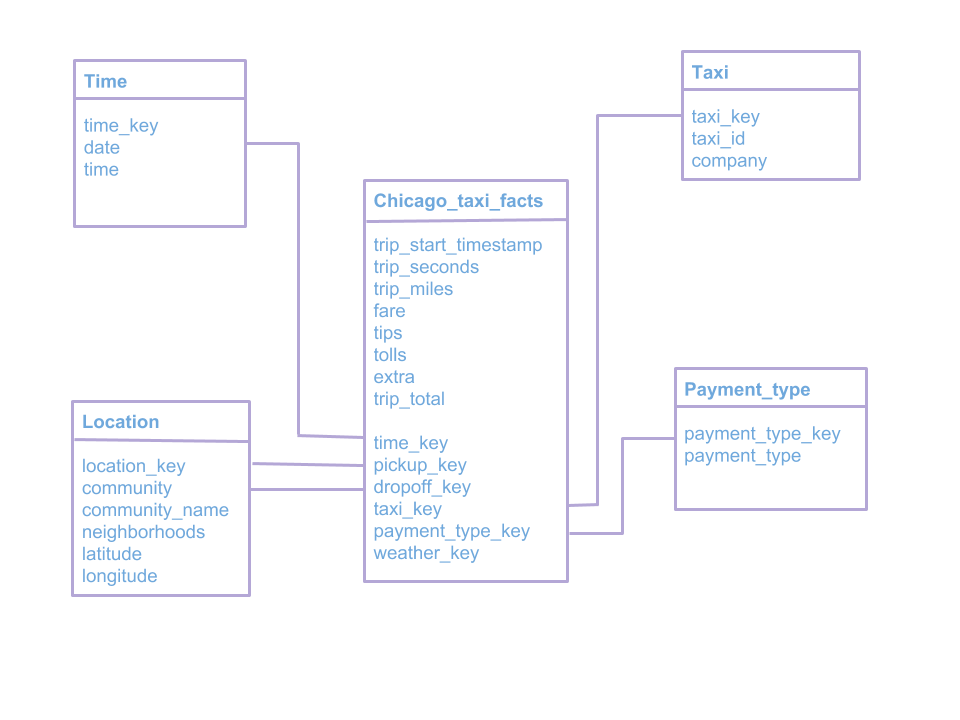

In [20]:
Image(filename = 'schema2.png', width = 800, height = 600)

__The database schema contains of a fact table and four dimension tables.__    
1. __Chicago_taxi_facts__ :trip_start_timestamp, trip_seconds, trip_miles,fare, tips, tolls, extras, trip_total, time_key, prickup_key, dropoff_key, taxi_key, payment_type_key       
2. __Location:__ location_key, community, latitude, longitude, community_name, neigbourhoods.  
3. __Time:__ time_key, date,time.   
4. __Taxi:__ taxi_key, taxi_id,company.     
5. __payment_type__: payment_type_key, payment_type

#### 2. Day dimension table
##### 1. display the content to be added the table

In [21]:
%%sql
SELECT DISTINCT trip_start_timestamp, time
FROM chicago
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


trip_start_timestamp,time
2016-01-15 00:00:00,8:45:00AM
2016-01-08 00:00:00,4:45:00PM
2016-01-08 00:00:00,9:45:00AM
2016-01-04 00:00:00,11:30:00AM
2016-01-14 00:00:00,11:30:00PM
2016-01-18 00:00:00,7:45:00PM
2016-01-01 00:00:00,1:15:00AM
2016-01-12 00:00:00,6:00:00AM
2016-01-09 00:00:00,5:00:00PM
2016-01-07 00:00:00,7:30:00PM


##### 2. Count the number of records of the table.

In [22]:
%%sql
SELECT COUNT(*)
FROM (SELECT DISTINCT trip_start_timestamp,time FROM chicago) as COUNT

 * postgresql://student@/project4
1 rows affected.


count
1920


##### 3. Create the time dimenstion table

In [23]:
%%sql
DROP TABLE IF EXISTS time;

CREATE TABLE time (
    time_key SERIAL PRIMARY KEY,
    date TIMESTAMP NOT NULL,
    time VARCHAR(64) NOT NULL
);

 * postgresql://student@/project4
Done.
Done.


[]

##### 4. Insert records in to the dimenstion table
The number of rows affected(1920) is exactly the records counted above. 

In [24]:
%%sql
INSERT INTO time (date, time)
SELECT DISTINCT trip_start_timestamp AS date, 
       time AS time 
FROM chicago;

 * postgresql://student@/project4
1920 rows affected.


[]

##### 5. Check and display

In [25]:
%%sql
SELECT *
FROM time
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


time_key,date,time
1,2016-01-15 00:00:00,8:45:00AM
2,2016-01-08 00:00:00,4:45:00PM
3,2016-01-08 00:00:00,9:45:00AM
4,2016-01-04 00:00:00,11:30:00AM
5,2016-01-14 00:00:00,11:30:00PM
6,2016-01-18 00:00:00,7:45:00PM
7,2016-01-01 00:00:00,1:15:00AM
8,2016-01-12 00:00:00,6:00:00AM
9,2016-01-09 00:00:00,5:00:00PM
10,2016-01-07 00:00:00,7:30:00PM


##### 6. Add these new identifiers (surrogate key) back to the fact table.

In [26]:
%%sql
ALTER TABLE chicago
ADD COLUMN time_key INTEGER,
ADD CONSTRAINT fk_date
    FOREIGN KEY (time_key)
    REFERENCES time (time_key);

 * postgresql://student@/project4
Done.


[]

In [27]:
%%sql
SELECT *
FROM chicago
LIMIT 2;

 * postgresql://student@/project4
2 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key
0,85,2016-01-13 00:00:00,6:15:00AM,180.0,0.4,24,24,4.5,0.0,0.0,0.0,4.5,Cash,41.901206994,-87.676355989,41.901206994,-87.676355989,Taxi Affiliation Services,None
1,6641,2016-01-06 00:00:00,11:15:00PM,420.0,0.0,8,28,7.25,0.0,0.0,0.0,7.25,Cash,41.89321636,-87.63784421,41.879255084,-87.642648998,Blue Ribbon Taxi Association Inc.,None


##### 7. Connect the fact and the dimension table
The number of rows affected is 348840, same of the number of rows in the dataset.

In [28]:
%%sql
UPDATE chicago
SET time_key = time.time_key
FROM time
WHERE chicago.trip_start_timestamp = time.date
AND chicago.time = time.time;

 * postgresql://student@/project4
348840 rows affected.


[]

In [29]:
%%sql
SELECT *
FROM chicago
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key
7615,251,2016-01-12 00:00:00,1:00:00AM,0.0,0.0,14,14,0.0,0.0,0.0,0.0,0.0,Cash,41.968069,-87.721559063,41.968069,-87.721559063,KOAM Taxi Association,1849
73776,1640,2016-01-14 00:00:00,5:45:00PM,180.0,0.0,6,6,5.0,0.0,0.0,0.0,5.0,Cash,41.944226601,-87.655998182,41.944226601,-87.655998182,Taxi Affiliation Services,513
76806,4484,2016-01-07 00:00:00,8:00:00AM,180.0,0.8,32,8,5.25,0.0,0.0,0.0,5.25,Cash,41.884987192,-87.620992913,41.89321636,-87.63784421,Taxi Affiliation Services,970
79065,2174,2016-01-08 00:00:00,6:15:00PM,240.0,0.6,8,8,5.25,0.0,0.0,0.0,5.25,Cash,41.899155613,-87.626210532,41.90749193,-87.63576009,Top Cab Affiliation,1421
79758,2174,2016-01-08 00:00:00,6:30:00PM,600.0,0.6,32,8,7.0,0.0,0.0,0.0,7.0,Cash,41.884987192,-87.620992913,41.892042136,-87.63186395,Top Cab Affiliation,1835
81127,8344,2016-01-15 00:00:00,1:00:00AM,600.0,0.1,28,8,10.5,0.0,0.0,0.0,10.5,Cash,41.874005383,-87.66351755,41.899602111,-87.633308037,Taxi Affiliation Services,958
82341,3123,2016-01-09 00:00:00,2:00:00AM,420.0,0.0,7,8,6.5,0.0,0.0,0.0,6.5,Cash,41.921854911,-87.646210977,41.90749193,-87.63576009,Dispatch Taxi Affiliation,1719
82434,5951,2016-01-08 00:00:00,6:45:00PM,1140.0,1.2,8,28,10.0,0.0,0.0,0.0,10.0,Cash,41.892042136,-87.63186395,41.88528132,-87.6572332,Taxi Affiliation Services,1788
82886,930,2016-01-01 00:00:00,1:15:00AM,240.0,0.0,32,32,4.65,0.0,0.0,0.0,4.65,Cash,41.884987192,-87.620992913,41.884987192,-87.620992913,Taxi Affiliation Services,7
84066,2174,2016-01-02 00:00:00,8:30:00PM,120.0,0.3,8,8,4.05,0.0,0.0,1.0,5.05,Cash,41.892507781,-87.626214906,41.892072635,-87.628874157,Top Cab Affiliation,1555


#### 3. location dimenstion table

#### 2.Add a new dataset
In our data resources, the community area only has a number but no names, to make it more straight forward, we join a dataset with the community names in Chicago.

#### Create the temp table for the new datasource

In [30]:
%%sql
DROP TABLE IF EXISTS temp;

CREATE TABLE temp (
    ID INTEGER,
    community_name VARCHAR(400),
    neighborhoods VARCHAR(400))

 * postgresql://student@/project4
Done.
Done.


[]

In [31]:
!wget https://s3.amazonaws.com/chicagotax/community+area.csv

--2018-12-10 16:56:25--  https://s3.amazonaws.com/chicagotax/community+area.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.171
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3722 (3.6K) [text/csv]
Saving to: ‘community+area.csv’

community+area.csv  100%[===================>]   3.63K  --.-KB/s    in 0s      

2018-12-10 16:56:25 (248 MB/s) - ‘community+area.csv’ saved [3722/3722]



In [32]:
!csvcut -n community+area.csv

  1: ﻿Number
  2: Community area
  3: Neighborhoods


#### Add the records into the table

In [33]:
!cp community+area.csv /tmp/community+area.csv

In [34]:
%%sql
COPY temp FROM '/tmp/community+area.csv'
CSV
HEADER;

 * postgresql://student@/project4
77 rows affected.


[]

In [35]:
%%sql
SELECT *
FROM temp
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


id,community_name,neighborhoods
5,North Center,Horner ParkRoscoe Village
6,Lake View,BoystownLake View EastGraceland WestSouth East RavenswoodWrigleyville
7,Lincoln Park,Old Town TrianglePark WestRanch TriangleSheffield NeighborsWrightwood Neighbors
21,Avondale,Belmont GardensChicago's Polish VillageKosciuszko Park
22,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
1,Rogers Park,East Rogers Park
2,West Ridge,Arcadia TerracePeterson ParkWest Rogers Park
3,Uptown,Buena ParkArgyle StreetMargate ParkSheridan Park
4,Lincoln Square,RavenswoodRavenswood GardensRockwell Crossing
9,Edison Park,Edison Park


##### 1. display the content to be added the table

In [36]:
%%sql
SELECT DISTINCT pickup_community_area, pickup_latitude, pickup_longitude
FROM chicago

UNION

SELECT DISTINCT dropoff_community_area, dropoff_latitude, dropoff_longitude
FROM chicago

LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


pickup_community_area,pickup_latitude,pickup_longitude
22,41.92556723,-87.712327602
22,41.929759047,-87.724267094
31,41.856333217,-87.659564239
24,41.892433156,-87.66962393
28,41.871689474,-87.654092652
22,41.915613238,-87.704479575
77,41.985476499,-87.65839767
76,41.980264315,-87.913624596
50,41.706125752,-87.598255838
11,41.978829526,-87.771166703


##### 2. Count the number of records of the table.

In [37]:
%%sql
SELECT COUNT(*)
FROM (SELECT DISTINCT pickup_community_area, pickup_latitude, pickup_longitude
FROM chicago

UNION

SELECT DISTINCT dropoff_community_area, dropoff_latitude, dropoff_longitude
FROM chicago) as COUNT

 * postgresql://student@/project4
1 rows affected.


count
408


##### 3. Create the time dimenstion table

In [38]:
%%sql
DROP TABLE IF EXISTS location;

CREATE TABLE location (
    location_key SERIAL PRIMARY KEY,
    community INTEGER NOT NULL,
    latitude NUMERIC NOT NULL,
    longitude NUMERIC NOT NULL,
    community_name VARCHAR(400),
    neighborhoods VARCHAR(400)
);

 * postgresql://student@/project4
Done.
Done.


[]

##### 4. Insert records in to the dimenstion table
The number of rows affected(408) is exactly the records counted above.

In [39]:
%%sql
INSERT INTO location (community, latitude, longitude)
SELECT DISTINCT pickup_community_area AS community,
       pickup_latitude AS latitude,
       pickup_longitude AS longitude
FROM chicago

UNION

SELECT DISTINCT dropoff_community_area AS community,
       dropoff_latitude AS latitude,
       dropoff_longitude AS longitude
FROM chicago;


 * postgresql://student@/project4
408 rows affected.


[]

In [40]:
%%sql
UPDATE location
SET community_name = temp.community_name
FROM temp
WHERE location.community = temp.id

 * postgresql://student@/project4
408 rows affected.


[]

In [41]:
%%sql
UPDATE location
SET neighborhoods = temp.neighborhoods
FROM temp
WHERE location.community = temp.id

 * postgresql://student@/project4
408 rows affected.


[]

##### 5. Check and display

In [42]:
%%sql
SELECT *
FROM location
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


location_key,community,latitude,longitude,community_name,neighborhoods
1,22,41.92556723,-87.712327602,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
2,22,41.929759047,-87.724267094,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
3,31,41.856333217,-87.659564239,Lower West Side,Heart of ChicagoHeart of ItalyPilsenEast Pilsen
4,24,41.892433156,-87.66962393,West Town,East VillageNoble SquarePolish DowntownPulaski ParkSmith ParkUkrainian VillageWicker Park
5,28,41.871689474,-87.654092652,Near West Side,GreektownLittle ItalyTri-Taylor
6,22,41.915613238,-87.704479575,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
7,77,41.985476499,-87.65839767,Edgewater,AndersonvilleEdgewater GlenEdgewater BeachMagnolia GlenLakewood/Balmoral
8,76,41.980264315,-87.913624596,O'Hare,Schorsch Forest View
9,50,41.706125752,-87.598255838,Pullman,Cottage Grove HeightsLondon Towne
10,11,41.978829526,-87.771166703,Jefferson Park,Gladstone Park


#### 6. Add constrains and new identifiers (surrogate key) back to the fact table.


1)Pick up location

In [43]:
%%sql
ALTER TABLE chicago
ADD COLUMN pickup_key INTEGER,
ADD CONSTRAINT fk_pickup
    FOREIGN KEY (pickup_key)
    REFERENCES location (location_key);

 * postgresql://student@/project4
Done.


[]

##### 7. Connect the fact and the dimension table
The number of rows affected is 348840, same of the number of rows in the dataset.


In [44]:
%%sql
UPDATE chicago
SET pickup_key = location.location_key
FROM location
WHERE chicago.pickup_community_area = location.community
AND chicago.pickup_latitude = location.latitude
AND chicago.pickup_longitude = location.longitude;

 * postgresql://student@/project4
348840 rows affected.


[]

2) Drop_off location

In [45]:
%%sql
ALTER TABLE chicago
ADD COLUMN dropoff_key INTEGER,
ADD CONSTRAINT fk_dropoff
    FOREIGN KEY (dropoff_key)
    REFERENCES location (location_key);

 * postgresql://student@/project4
Done.


[]

In [46]:
%%sql
UPDATE chicago
SET dropoff_key = location.location_key
FROM location
WHERE chicago.dropoff_community_area = location.community
AND chicago.dropoff_latitude = location.latitude
AND chicago.dropoff_longitude = location.longitude;

 * postgresql://student@/project4
348840 rows affected.


[]

In [47]:
%%sql
SELECT *
FROM chicago
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key,pickup_key,dropoff_key
84066,2174,2016-01-02 00:00:00,8:30:00PM,120.0,0.3,8,8,4.05,0.0,0.0,1.0,5.05,Cash,41.892507781,-87.626214906,41.892072635,-87.628874157,Top Cab Affiliation,1555,367,173
84429,107,2016-01-17 00:00:00,1:45:00AM,240.0,0.0,8,8,5.75,0.0,0.0,0.0,5.75,Cash,41.905857769,-87.630865027,41.89321636,-87.63784421,Taxi Affiliation Services,534,107,335
84878,4710,2016-01-08 00:00:00,7:30:00PM,420.0,0.6,32,32,6.0,0.0,0.0,0.0,6.0,Cash,41.880994471,-87.632746489,41.880994471,-87.632746489,Top Cab Affiliation,661,204,204
85413,7145,2016-01-04 00:00:00,10:15:00PM,300.0,0.9,8,8,6.0,0.0,0.0,0.0,6.0,Cash,41.89321636,-87.63784421,41.900221297,-87.629105186,Top Cab Affiliation,1516,335,44
85887,6061,2016-01-07 00:00:00,2:30:00PM,420.0,0.8,8,32,7.0,0.0,0.0,0.0,7.0,Cash,41.892042136,-87.63186395,41.880994471,-87.632746489,Taxi Affiliation Services,307,181,204
85972,4700,2016-01-04 00:00:00,4:45:00PM,180.0,0.5,8,8,4.75,0.0,0.0,0.0,4.75,Cash,41.89503345,-87.619710672,41.902788048,-87.62614559,Northwest Management LLC,787,13,349
86238,4297,2016-01-12 00:00:00,4:15:00PM,300.0,0.0,8,8,6.25,0.0,0.0,0.0,6.25,Cash,41.892042136,-87.63186395,41.902788048,-87.62614559,Taxi Affiliation Services,273,181,349
86509,103,2016-01-14 00:00:00,11:15:00AM,600.0,0.0,8,32,7.5,0.0,0.0,0.0,7.5,Cash,41.892042136,-87.63186395,41.880994471,-87.632746489,Northwest Management LLC,794,181,204
87591,8170,2016-01-05 00:00:00,10:00:00AM,180.0,0.5,32,8,4.75,0.0,0.0,0.0,4.75,Cash,41.884987192,-87.620992913,41.892042136,-87.63186395,Taxi Affiliation Services,1601,369,181
87723,4419,2016-01-07 00:00:00,7:15:00PM,0.0,0.0,28,28,3.25,0.0,0.0,27.0,30.25,Cash,41.88528132,-87.6572332,41.88528132,-87.6572332,Dispatch Taxi Affiliation,966,260,260


#### 4. Taxi Dimension Table

##### 1. display the content to be added the table

In [48]:
%%sql
SELECT DISTINCT taxi_id, company
FROM chicago
ORDER BY taxi_id
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


taxi_id,company
3,Taxi Affiliation Services
4,Taxi Affiliation Services
6,Blue Ribbon Taxi Association Inc.
7,Choice Taxi Association
8,Choice Taxi Association
10,Choice Taxi Association
20,Taxi Affiliation Services
22,Taxi Affiliation Services
27,Taxi Affiliation Services
29,Taxi Affiliation Services


##### 2. Count the number of records of the table.

In [49]:
%%sql
SELECT COUNT(*)
FROM (SELECT DISTINCT taxi_id, company FROM chicago) as COUNT

 * postgresql://student@/project4
1 rows affected.


count
2598


##### 3. Create the taxi dimenstion table

In [50]:
%%sql
DROP TABLE IF EXISTS taxi;

CREATE TABLE taxi (
    taxi_key SERIAL PRIMARY KEY,
    taxi_id INTEGER NOT NULL,
    company VARCHAR(500) NOT NULL
);

 * postgresql://student@/project4
Done.
Done.


[]

##### 4. Insert records in to the dimenstion table
The number of rows affected(2598) is exactly the records counted above.

In [51]:
%%sql
INSERT INTO taxi (taxi_id, company)
SELECT DISTINCT taxi_id, company
FROM chicago;

 * postgresql://student@/project4
2598 rows affected.


[]

#### 5. Add constrains and new identifiers (surrogate key) back to the fact table.


In [52]:
%%sql
ALTER TABLE chicago
ADD COLUMN taxi_key INTEGER,
ADD CONSTRAINT fk_taxi_key
    FOREIGN KEY (taxi_key)
    REFERENCES taxi (taxi_key)

 * postgresql://student@/project4
Done.


[]

In [53]:
%%sql
SELECT *
FROM chicago
LIMIT 10;

 * postgresql://student@/project4
10 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key,pickup_key,dropoff_key,taxi_key
87723,4419,2016-01-07 00:00:00,7:15:00PM,0.0,0.0,28,28,3.25,0.0,0.0,27.0,30.25,Cash,41.88528132,-87.6572332,41.88528132,-87.6572332,Dispatch Taxi Affiliation,966,260,260,None
87817,5713,2016-01-11 00:00:00,4:15:00PM,900.0,0.0,3,8,16.5,0.0,0.0,0.0,16.5,Cash,41.96581197,-87.655878786,41.899602111,-87.633308037,Taxi Affiliation Services,1589,390,363,None
87863,225,2016-01-03 00:00:00,2:00:00AM,0.0,0.0,7,7,3.25,0.0,0.0,0.0,3.25,Cash,41.922686284,-87.649488729,41.922686284,-87.649488729,Dispatch Taxi Affiliation,1798,72,72,None
88051,5557,2016-01-13 00:00:00,11:30:00AM,300.0,0.0,8,8,5.0,0.0,0.0,0.0,5.0,Cash,41.898331794,-87.620762865,41.89503345,-87.619710672,Choice Taxi Association,1558,340,13,None
89487,7767,2016-01-13 00:00:00,8:45:00AM,180.0,0.4,8,32,4.5,0.0,0.0,0.0,4.5,Cash,41.892072635,-87.628874157,41.884987192,-87.620992913,5129 - 87128,474,173,369,None
89539,2320,2016-01-10 00:00:00,1:00:00PM,180.0,0.6,32,32,4.75,0.0,0.0,0.0,4.75,Cash,41.884987192,-87.620992913,41.877406123,-87.621971652,Choice Taxi Association,1686,369,16,None
90497,3356,2016-01-11 00:00:00,6:00:00PM,1200.0,0.0,32,24,14.0,0.0,0.0,0.0,14.0,Cash,41.878865584,-87.625192142,41.901206994,-87.676355989,Choice Taxi Association,366,120,53,None
93582,5238,2016-01-11 00:00:00,4:45:00PM,1440.0,4.9,28,6,17.0,0.0,0.0,0.0,17.0,Cash,41.874005383,-87.66351755,41.944226601,-87.655998182,Taxi Affiliation Services,729,76,147,None
95077,3024,2016-01-03 00:00:00,9:15:00PM,420.0,0.0,28,28,6.75,0.0,0.0,0.0,6.75,Cash,41.874005383,-87.66351755,41.874005383,-87.66351755,Taxi Affiliation Services,686,76,76,None
95394,6723,2016-01-07 00:00:00,5:45:00PM,420.0,0.6,8,8,6.0,0.0,0.0,0.0,6.0,Cash,41.890922026,-87.618868355,41.898331794,-87.620762865,Top Cab Affiliation,667,40,340,None


In [54]:
%%sql
DROP INDEX IF EXISTS idx_taxi;

CREATE INDEX idx_taxi ON taxi (taxi_id, company);

 * postgresql://student@/project4
Done.
Done.


[]

In [55]:
%%sql
SELECT * FROM taxi
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


taxi_key,taxi_id,company
1,3,Taxi Affiliation Services
2,4,Taxi Affiliation Services
3,6,Blue Ribbon Taxi Association Inc.
4,7,Choice Taxi Association
5,8,Choice Taxi Association
6,10,Choice Taxi Association
7,20,Taxi Affiliation Services
8,22,Taxi Affiliation Services
9,27,Taxi Affiliation Services
10,29,Taxi Affiliation Services


##### 7. Connect the fact and the dimension table
The number of rows affected is 348840, same of the number of rows in the dataset.


In [56]:
%%sql
UPDATE chicago
SET taxi_key = taxi.taxi_key
FROM taxi
WHERE chicago.taxi_id = taxi.taxi_id 
AND chicago.company = taxi.company 

 * postgresql://student@/project4
348840 rows affected.


[]

In [57]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key,pickup_key,dropoff_key,taxi_key
95077,3024,2016-01-03 00:00:00,9:15:00PM,420.0,0.0,28,28,6.75,0.0,0.0,0.0,6.75,Cash,41.874005383,-87.66351755,41.874005383,-87.66351755,Taxi Affiliation Services,686,76,76,897
95394,6723,2016-01-07 00:00:00,5:45:00PM,420.0,0.6,8,8,6.0,0.0,0.0,0.0,6.0,Cash,41.890922026,-87.618868355,41.898331794,-87.620762865,Top Cab Affiliation,667,40,340,1992
95439,3581,2016-01-07 00:00:00,7:00:00AM,180.0,0.0,16,14,4.0,0.0,0.0,0.0,4.0,Cash,41.953582125,-87.72345239,41.968069,-87.721559063,Dispatch Taxi Affiliation,543,65,24,1055
95929,4881,2016-01-13 00:00:00,4:30:00PM,540.0,1.4,28,8,7.75,0.0,0.0,0.0,7.75,Cash,41.885300022,-87.642808466,41.904935302,-87.649907226,Choice Taxi Association,373,174,265,1445
96703,4330,2016-01-14 00:00:00,9:00:00PM,1140.0,9.5,28,77,26.0,0.0,0.0,0.0,26.0,Cash,41.874005383,-87.66351755,41.9867118,-87.663416405,Taxi Affiliation Services,1156,76,208,1272
98191,7145,2016-01-02 00:00:00,9:30:00AM,0.0,0.0,11,11,3.25,0.0,0.0,0.0,3.25,Cash,41.978829526,-87.771166703,41.978829526,-87.771166703,Top Cab Affiliation,912,10,10,2128
98741,4710,2016-01-15 00:00:00,1:15:00AM,240.0,0.4,8,8,5.0,0.0,0.0,0.0,5.0,Cash,41.892042136,-87.63186395,41.892042136,-87.63186395,Top Cab Affiliation,1142,181,181,1392
100331,6062,2016-01-17 00:00:00,9:45:00AM,180.0,0.0,8,8,5.0,0.0,0.0,2.0,7.0,Cash,41.892507781,-87.626214906,41.891971508,-87.612945414,Taxi Affiliation Services,488,367,334,1793
102271,1760,2016-01-20 00:00:00,8:45:00AM,840.0,0.0,7,22,11.0,0.0,0.0,0.0,11.0,Cash,41.922686284,-87.649488729,41.92276062,-87.699155343,Taxi Affiliation Services,997,72,105,527
102319,6509,2016-01-13 00:00:00,9:00:00PM,1680.0,15.9,6,56,40.0,0.0,0.0,1.0,41.0,Cash,41.944226601,-87.655998182,41.79259236,-87.769615453,Choice Taxi Association,823,147,326,1922


#### 5. Payment type table
##### 1. display the content to be added the table

In [58]:
%%sql
SELECT DISTINCT payment_type
FROM chicago

 * postgresql://student@/project4
5 rows affected.


payment_type
No Charge
Unknown
Dispute
Cash
Credit Card


##### 2. Create the time dimenstion table

In [59]:
%%sql
DROP TABLE IF EXISTS payment_type;

CREATE TABLE payment_type (
    payment_type_key SERIAL PRIMARY KEY,
    payment_type VARCHAR(20) NOT NULL
);

 * postgresql://student@/project4
Done.
Done.


[]

##### 3. Insert records in to the dimenstion table
The number of rows affected(5) is exactly the records counted above. 

In [60]:
%%sql
INSERT INTO payment_type (payment_type)
SELECT DISTINCT payment_type
FROM chicago;

 * postgresql://student@/project4
5 rows affected.


[]

##### 4. Add constrains and new identifiers (surrogate key) back to the fact table.


In [61]:
%%sql
ALTER TABLE chicago
ADD COLUMN payment_type_key INTEGER,
ADD CONSTRAINT fk_payment_type_key
    FOREIGN KEY (payment_type_key)
    REFERENCES payment_type (payment_type_key)

 * postgresql://student@/project4
Done.


[]

##### 5. Connect the fact and the dimension table
The number of rows affected is 348840, same of the number of rows in the dataset.


In [62]:
%%sql
UPDATE chicago
SET payment_type_key = payment_type.payment_type_key
FROM payment_type
WHERE chicago.payment_type = payment_type.payment_type

 * postgresql://student@/project4
348840 rows affected.


[]

In [63]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


id,taxi_id,trip_start_timestamp,time,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extra,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key
102271,1760,2016-01-20 00:00:00,8:45:00AM,840.0,0.0,7,22,11.0,0.0,0.0,0.0,11.0,Cash,41.922686284,-87.649488729,41.92276062,-87.699155343,Taxi Affiliation Services,997,72,105,527,4
102319,6509,2016-01-13 00:00:00,9:00:00PM,1680.0,15.9,6,56,40.0,0.0,0.0,1.0,41.0,Cash,41.944226601,-87.655998182,41.79259236,-87.769615453,Choice Taxi Association,823,147,326,1922,4
103181,8688,2016-01-12 00:00:00,1:00:00PM,240.0,0.5,32,32,5.0,2.0,0.0,0.0,7.0,Credit Card,41.880994471,-87.632746489,41.884987192,-87.620992913,Dispatch Taxi Affiliation,656,204,369,2573,5
103498,3352,2016-01-05 00:00:00,3:00:00PM,480.0,0.1,8,32,6.5,0.0,0.0,0.0,6.5,Cash,41.89503345,-87.619710672,41.880994471,-87.632746489,Choice Taxi Association,1367,13,204,989,4
108658,4601,2016-01-10 00:00:00,5:45:00AM,120.0,0.7,6,3,5.0,2.0,0.0,0.0,7.0,Credit Card,41.944226601,-87.655998182,41.96581197,-87.655878786,Dispatch Taxi Affiliation,137,147,390,1357,5
109568,6914,2016-01-02 00:00:00,12:30:00PM,780.0,2.6,8,8,9.75,0.0,0.0,0.0,9.75,Cash,41.89321636,-87.63784421,41.89321636,-87.63784421,Taxi Affiliation Services,271,335,335,2052,4
109843,7672,2016-01-20 00:00:00,11:45:00AM,300.0,0.0,32,8,6.25,0.0,0.0,0.0,6.25,Cash,41.880994471,-87.632746489,41.89503345,-87.619710672,Taxi Affiliation Services,1779,204,13,2287,4
110065,1249,2016-01-05 00:00:00,3:45:00PM,360.0,0.0,8,8,6.25,0.0,0.0,1.0,7.25,Cash,41.899155613,-87.626210532,41.89321636,-87.63784421,Choice Taxi Association,263,61,335,374,4
111334,3612,2016-01-13 00:00:00,1:00:00PM,600.0,0.0,8,8,7.25,0.0,0.0,0.0,7.25,Cash,41.900221297,-87.629105186,41.892042136,-87.63186395,Taxi Affiliation Services,773,44,181,1067,4
111434,6631,2016-01-11 00:00:00,7:45:00AM,180.0,0.7,24,28,5.0,0.0,0.0,0.0,5.0,Cash,41.89830587,-87.653613982,41.885300022,-87.642808466,KOAM Taxi Association,905,43,174,1957,4


#### Drop the unnecessary columns

In [64]:
%%sql
ALTER TABLE chicago
DROP COLUMN taxi_id,
DROP COLUMN company,
DROP COLUMN time,
DROP COLUMN dropoff_community_area,
DROP COLUMN pickup_community_area,
DROP COLUMN pickup_latitude,
DROP COLUMN pickup_longitude,
DROP COLUMN dropoff_latitude,
DROP COLUMN dropoff_longitude,
DROP COLUMN payment_type,
DROP COLUMN id

 * postgresql://student@/project4
Done.


[]

#### Display the final fact table and the dimension tables.

In [65]:
%%sql
SELECT * FROM chicago
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


trip_start_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key
2016-01-13 00:00:00,600.0,0.0,7.25,0.0,0.0,0.0,7.25,773,44,181,1067,4
2016-01-11 00:00:00,180.0,0.7,5.0,0.0,0.0,0.0,5.0,905,43,174,1957,4
2016-01-09 00:00:00,540.0,0.0,8.0,0.0,0.0,1.0,9.0,701,40,43,1667,4


In [66]:
%%sql
SELECT * FROM time
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


time_key,date,time
1,2016-01-15 00:00:00,8:45:00AM
2,2016-01-08 00:00:00,4:45:00PM
3,2016-01-08 00:00:00,9:45:00AM


In [67]:
%%sql
SELECT * FROM location
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


location_key,community,latitude,longitude,community_name,neighborhoods
1,22,41.92556723,-87.712327602,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
2,22,41.929759047,-87.724267094,Logan Square,Belmont GardensBucktownKosciuszko ParkPalmer Square
3,31,41.856333217,-87.659564239,Lower West Side,Heart of ChicagoHeart of ItalyPilsenEast Pilsen


In [68]:
%%sql
SELECT * FROM taxi
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


taxi_key,taxi_id,company
1,3,Taxi Affiliation Services
2,4,Taxi Affiliation Services
3,6,Blue Ribbon Taxi Association Inc.


In [69]:
%%sql
SELECT * FROM payment_type
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


payment_type_key,payment_type
1,No Charge
2,Unknown
3,Dispute


## Part 3 - Analysis (35 points)

_Explore and analyze your data in its wrangled form.  Follow through
on the themes you identified in Part 1 with queries or scripts that
answer the questions you had in mind.  Be clear about the answers
you discover, discussing them and whether the results match your
expectations.  Include charts or other visuals that support your
analysis.  You may use Tableau, matplotlib, ggplot, or other tools
we have not covered in class for visualization (and only for
visualization), but be sure to export images from those tools and
to include any images properly in your notebook writeup and slides._

### What we focus on:

1. Which time does the customers use taxies most?
2. For the peak hours, what is do peopel's desitnation?
3. Which area is the most popular for people to use taxi?
4. How is the taxi priced, which company has highest initial charge?
5. Why some company have high initial charge?
6. Whcih ccompany has initial charge?
7. Why some companies have high tips?
8. Which payment type does people usually prefer?
9. What is trip total difference between weekends and weekdays?
10. What is the relationship between time and pickup location?

#### 1. Which time does the customers use taxies most?

__Expectations__: The peak hour of using taxi service will be the time when people go for work or go home.
 
__Finding:__
6:45-7:15 pm is the peak when people use taxi most. We think it is because most of people off work at tis time period.  For taxi company, they should allocate more taxi to during this time period to balance the supply and demand. Government can improve the capacity of public transportation in order to encourage people using less taxi service.

In [70]:
%matplotlib inline

**People tend to use taxi service in the morning(AM) or evening(PM)?**    
The following results show that the number of records after 12:00 am is much more than that in the morning. Thus in Chicago, the taxi services is busier in the afternoon .

(1) Morning(AM)

In [71]:
%%sql
SELECT COUNT(*)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
WHERE time.time LIKE '%AM%'

 * postgresql://student@/project4
1 rows affected.


count
125719


(2) Afternoon (PM)

In [72]:
%%sql
SELECT COUNT(*)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
WHERE time.time LIKE '%PM%'

 * postgresql://student@/project4
1 rows affected.


count
223121


In [73]:
%%sql
SELECT time.time, count(time.time)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
GROUP BY time.time
ORDER BY count(time.time) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


time,count
6:45:00PM,6107
7:15:00PM,6070
7:00:00PM,6044
7:45:00PM,5974
7:30:00PM,5974
8:00:00PM,5958
6:15:00PM,5737
6:30:00PM,5735
8:15:00PM,5579
6:00:00PM,5412


#### 2. During the peak hours, how far does people always travel on taxi?
The following result shows that taxi riders in Chicago tend to travel only for short distances after work. It indicates that people in Chicago usually use taxi as a short-distance transportation.

In [74]:
%%sql
SELECT chicago.trip_miles,count(chicago.trip_miles)
from chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
WHERE time.time = '6:45:00PM'
GROUP BY chicago.trip_miles
ORDER BY count(chicago.trip_miles) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


trip_miles,count
0.0,1913
0.1,424
0.9,206
0.8,202
1.1,195
1.0,190
0.7,163
0.6,150
1.2,142
1.3,139


#### 3. Which areas have the most number of people using taxi?

(1) Most popular pick up community.

__Expectations__: Community which develops quickly and has better economic condition.  
 
__Results__: Community 8 and 32, which near north side, are the most popular pickup location. This area is the center of Chicago. For example, Etihad Airways and Qatar Airways have offices in the John Hancock Center. The Wrigley Company had its headquarters in the Wrigley Building before moving to Goose Island, also within this area.

In [75]:
%%sql
SELECT location.community, location.community_name, count(location.community)
FROM chicago
LEFT JOIN location
ON chicago.pickup_key = location.location_key
GROUP BY location.community, location.community_name
ORDER BY count(location.community) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,community_name,count
8,Near North Side,115783
32,Loop,83911
28,Near West Side,35870
6,Lake View,22132
76,O'Hare,17789
7,Lincoln Park,17171
24,West Town,11314
56,Garfield Ridge,6882
3,Uptown,5882
33,Near South Side,5443


In [76]:
!wget https://s3.amazonaws.com/chicagotax/Q2.png

--2018-12-10 16:56:59--  https://s3.amazonaws.com/chicagotax/Q2.png
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39692 (39K) [image/png]
Saving to: ‘Q2.png’

Q2.png              100%[===================>]  38.76K  --.-KB/s    in 0.002s  

2018-12-10 16:56:59 (16.3 MB/s) - ‘Q2.png’ saved [39692/39692]



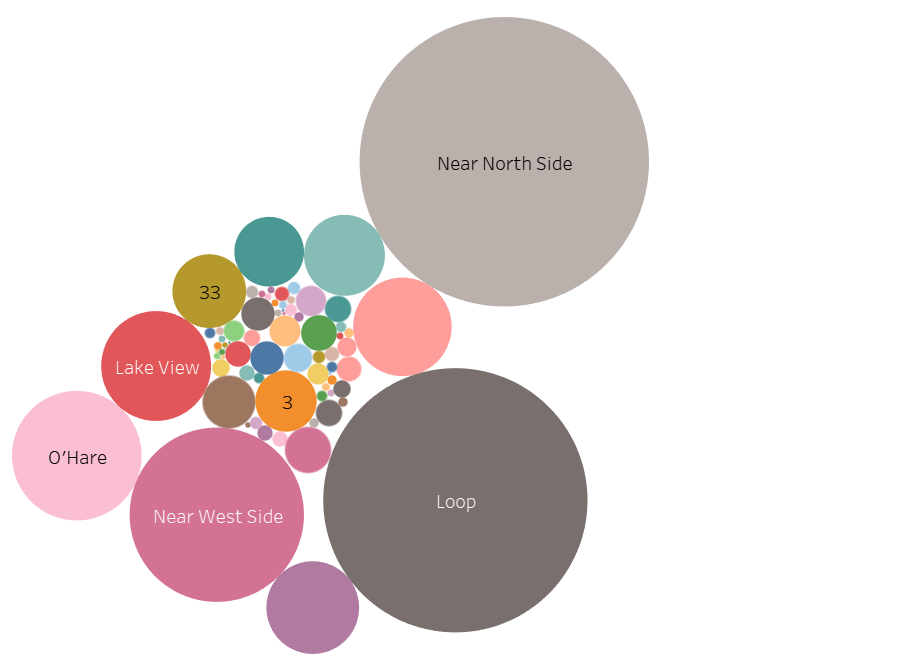

In [77]:
Image(filename = 'Q2.png', width = 800, height = 600)

(2) Most popular drop off community.

__Expectations__ : Community which provides a comfortable living area or provides many job opportunities would be people's most frequently destination.
 
__Findings__: Community 8 (Near North Side) and 32 (Loop) are still the most popular drop_off communities. Google, Etihad Airways, Qatar Airways, the headquarters of Tribune company are all in these two communities. It is likely that people in these two communities have higher income or maybe public transportation here is crowded. So people are more willing to take taxi.

In [78]:
%%sql
SELECT location.community, location.community_name, count(location.community)
FROM chicago
LEFT JOIN location
ON chicago.dropoff_key = location.location_key
GROUP BY location.community, location.community_name
ORDER BY count(location.community) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,community_name,count
8,Near North Side,103546
32,Loop,71313
28,Near West Side,38082
6,Lake View,25467
7,Lincoln Park,22582
24,West Town,16948
76,O'Hare,10235
33,Near South Side,7591
3,Uptown,7328
22,Logan Square,6325


The results do not show substaintial difference on the popularity between pick up and drop off community.

#### 4. How is the taxi priced, which company received most tips on average(which probably means it has greatest service)

##### (1)How is the taxi priced, relationship between durations and total price for different company

__Expectation__:  We assume the price increase per mile will impact the total trip.

__Finding__:  By using average price minus start price and then divided by average miles, we create a column named price/mile to represent the pricing strategy after the very first mile. Some negative values poped out. We estimate the taxi initial charge by checking the average price of each company when mile is 0， 4053 - 40193 Adwar H. Nikola has the highest initial charge of 43.11 and 1247 - 72807 Daniel Ayertey has the lowest  of 11.65. The bar chart visualize the price gap directly so we can see the range of the start price of all taxi company of Chicago is 31.46. But why some companies charge higher?

In [79]:
%%sql
SELECT company, round(AVG(chicago.trip_total),2) AS start_price
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
WHERE chicago.trip_miles = 0
GROUP BY taxi.company
ORDER BY AVG(chicago.trip_total) DESC
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


company,start_price
4053 - 40193 Adwar H. Nikola,43.11
3011 - 66308 JBL Cab Inc.,24.90
Suburban Dispatch LLC,22.96
6747 - Mueen Abdalla,12.89
1247 - 72807 Daniel Ayertey,11.65


<BarContainer object of 5 artists>

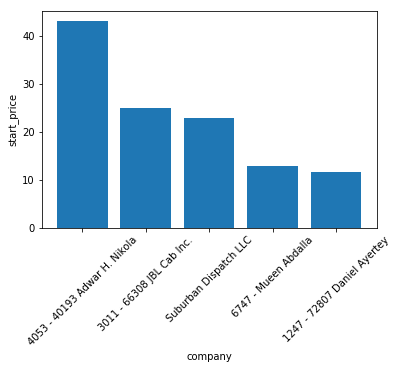

In [80]:
_.bar()

In [81]:
%%sql
SELECT company, round(AVG(chicago.trip_total),2) AS start_price
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
WHERE chicago.trip_miles = 0
GROUP BY taxi.company
ORDER BY AVG(chicago.trip_total) ASC
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


company,start_price
4615 - 83503 Tyrone Henderson,2.36
3623 - 72222 Arrington Enterprises,3.25
2092 - 61288 Sbeih company,3.25
3620 - 52292 David K. Cab Corp.,3.25
4197 - 41842 Royal Star,3.25


In this part we find the company name with the 5 lowest initial charge by following an acending order. 2092 - 61288 Sbeih company, 4197 - 41842 Royal Star, 5006 - 39261 Salifu Bawa and 3620 - 52292 David K. Cab Corp have the same price as 3.25 at the start. 4615 - 83503 Tyrone Henderson has the cheapest start price of 2.36.

<BarContainer object of 5 artists>

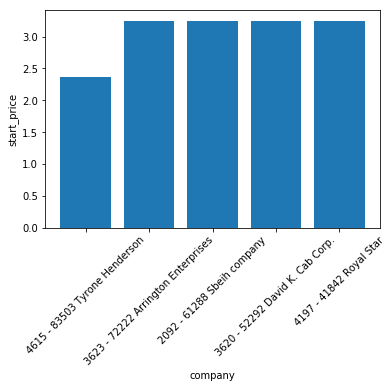

In [82]:
_.bar()

In [83]:
chi = pd.read_csv('Chicago_Taxi.csv')

In [84]:
company = chi['company'].unique().tolist()
start_price = []
avg_price = []
avg_mile = []
for i in company:
    co = chi[chi['company'] == i]
    avg_price.append(round(co['trip_total'].mean(),2))
    avg_mile.append(round(co['trip_miles'].mean(),2))
    co0 = co[co['trip_miles']== 0] 
    start_price.append(round(co0['trip_total'].mean(),2))

In [85]:
df_com = pd.DataFrame({"company":company,"start_price":start_price,"avg_price":avg_price,'avg_mile':avg_mile}) 
df_com = df_com.dropna()

In [86]:
df_com.head(3)

,avg_mile,avg_price,company,start_price
0,1.77,14.28,Taxi Affiliation Services,10.65
1,0.13,13.17,Blue Ribbon Taxi Association Inc.,11.23
2,3.21,14.13,Dispatch Taxi Affiliation,11.46


In [87]:
df_com['price/mile'] = (df_com['avg_price']-df_com['start_price'])/df_com['avg_mile']

In [88]:
df_com = df_com.sort_values(by=['price/mile'])
df_com =df_com.dropna()
df_com = df_com.reset_index(drop=True)

In [89]:
df_com.head()

,avg_mile,avg_price,company,start_price,price/mile
0,2.79,12.56,3011 - 66308 JBL Cab Inc.,24.90,-4.422939
1,6.90,29.93,4053 - 40193 Adwar H. Nikola,43.11,-1.910145
2,1.83,9.27,3094 - 24059 G.L.B. Cab Co,10.46,-0.650273
3,2.64,12.50,Northwest Management LLC,10.89,0.609848
4,4.55,15.01,1247 - 72807 Daniel Ayertey,11.65,0.738462


In the following figure, the x axis means different companies, y axis means the price, yellow bars represent the initial charge of the first mile and the blue bars represent the price per mile after the first mile of the trip. 3011 - 66308 JBL Cab Inc., 3094 - 24059 G.L.B. Cab Co and 4053 - 40193 Adwar H. Nikola have negative value. Nearly 20% of the companies‘ price per mile is almost 10% of the start price. 20% of the companies‘ price per mile is equal or more than their start price.

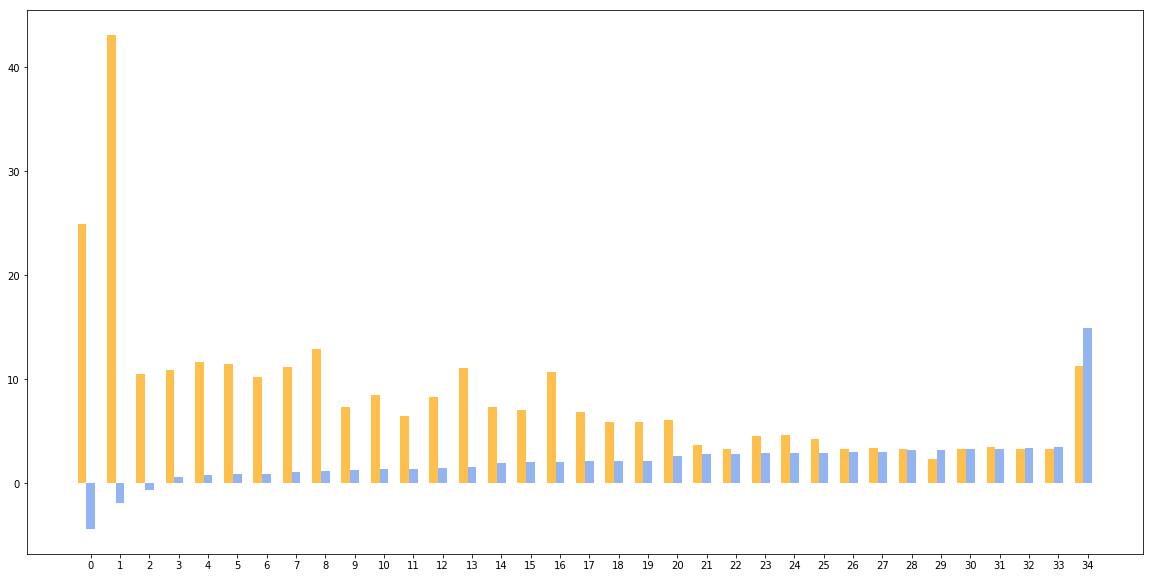

In [90]:
plt.figure(figsize=(20,10))

# Make a fake dataset:
height1 = df_com['start_price'].tolist()
bars1 = df_com.index.tolist()
y_pos1 = np.arange(len(bars1))

height2 = df_com['price/mile'].tolist()
bars2 = df_com.index.tolist()
y_pos2 = np.arange(len(bars2))+0.3

# Create bars
plt.bar(y_pos1, height1 ,color = 'orange', width = 0.3, alpha = 0.7)
plt.bar(y_pos2, height2 ,color = 'cornflowerblue', width = 0.3, alpha = 0.7 )
 
# Create names on the x-axis
plt.xticks(y_pos2, bars2)


# Show graphic
plt.show()

Mile 0 is meaningless, so we delete all the trips with 0 mile.

In [91]:
%%sql
SELECT COUNT(*)
FROM chicago
WHERE chicago.trip_miles = 0

 * postgresql://student@/project4
1 rows affected.


count
107557


In [92]:
%%sql
DELETE FROM chicago
WHERE trip_miles = 0;

 * postgresql://student@/project4
107557 rows affected.


[]

In [93]:
%%sql
SELECT COUNT(*)
FROM chicago

 * postgresql://student@/project4
1 rows affected.


count
241283


In [94]:
%%sql
SELECT *
FROM chicago
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


trip_start_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key
2016-01-14 00:00:00,180.0,0.6,4.75,1.0,0.0,0.0,5.75,1430,181,52,1807,5
2016-01-10 00:00:00,840.0,8.4,23.0,0.0,0.0,0.0,23.0,1033,76,390,634,4
2016-01-07 00:00:00,420.0,0.8,6.0,0.0,0.0,0.0,6.0,1740,340,335,1729,4
2016-01-04 00:00:00,60.0,0.5,4.05,0.0,0.0,0.0,4.05,520,369,369,1167,4
2016-01-06 00:00:00,360.0,1.2,6.25,0.0,0.0,0.0,6.25,497,260,174,1458,4


We ignore tolls, extra and calculate fare per mile without minus the initial charge 

In [95]:
%%sql
SELECT taxi.company,round(AVG(fare/trip_miles),2)AS fare_per_mile
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
GROUP BY taxi.company 
ORDER BY AVG(fare/trip_miles) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


company,fare_per_mile
Blue Ribbon Taxi Association Inc.,68.92
Taxi Affiliation Services,24.19
5997 - 65283 AW Services Inc.,6.71
4197 - 41842 Royal Star,6.66
2192 - 73487 Zeymane Corp,6.60
Chicago Medallion Management,6.18
5129 - 87128,6.16
5006 - 39261 Salifu Bawa,6.14
6488 - 83287 Zuha Taxi,6.08
6057 - 24657 Richard Addo,6.05


#### 5. Why some companies have higher start price?

For all these taxi companies with high initial price, we can analyze the area they mostly serving and understand their target market and business strategy. We analyze two companies which have high start price.

__Expectations__: High initial price may focus on the target group at the CBD area with higher income.

__Findings__: Most taxi companies set higher initial price in community 8 and 32, which is the central part of Chicago than in other communities. Therefore there is a price discrimination phenomenon

In [96]:
%%sql
SELECT taxi.company,location.community, round(AVG(chicago.trip_total),2) AS start_price
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
left join location
on chicago.pickup_key = location.location_key
WHERE chicago.trip_miles = 0
GROUP BY (location.community,taxi.company)
ORDER BY taxi.company

 * postgresql://student@/project4
0 rows affected.


company,community,start_price


#### 6.Which company received most tips on average?

We made the bar chart of the top 5 taxi companies with the highest average tips.

Findings: In the top 10 taxi companies which receives most tips. 2241 - 44667 Manuel Alonso has the highest average tip, which is almost 6 dollars. The rest 9 companies are tipped around 2 to 3 dollars on average.

In [97]:
%%sql
SELECT  taxi.company, round(AVG(chicago.tips),2) AS Average_tip
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
GROUP BY taxi.company
ORDER BY AVG(chicago.tips) DESC
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


company,average_tip
2241 - 44667 Manuel Alonso,5.87
3620 - 52292 David K. Cab Corp.,3.72
4053 - 40193 Adwar H. Nikola,3.55
4623 - 27290 Jay Kim,3.28
2823 - 73307 Seung Lee,3.25


<BarContainer object of 5 artists>

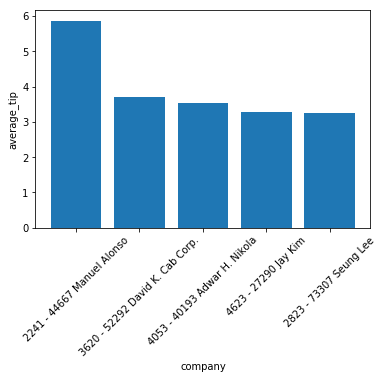

In [98]:
_.bar()

Then we have a look at the companies with the least tips

In [99]:
%%sql
SELECT  taxi.company, round(AVG(chicago.tips),2) AS Average_tip
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
GROUP BY taxi.company
ORDER BY AVG(chicago.tips) ASC
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


company,average_tip
3669 - 85800 Jordan Taxi Inc,0.00
2092 - 61288 Sbeih company,0.09
6743 - 78771 Luhak Corp,0.14
5997 - 65283 AW Services Inc.,0.27
3094 - 24059 G.L.B. Cab Co,0.31


<BarContainer object of 5 artists>

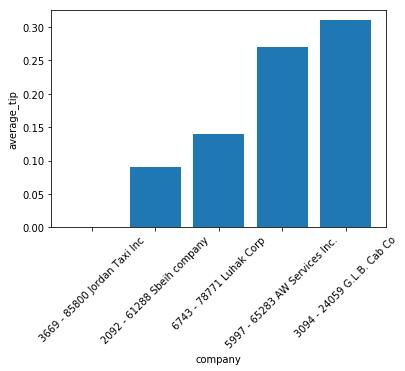

In [100]:
_.bar()

#### 7. Why some companies have higher tips?

__Findings:__ people worked at the central area with hivher income give higher tips. Same taxi company receives different tip amount in different communities. 4623 - 27290 Jay Kim, 3623 - 72222 Arrington Enterprises, 5074 - 54002 Ahzmi Inc, 585 - 88805 Valley Cab Co and Chicago Elite Cab Corp receive no tips no matter in which community.

In [101]:
%%sql
SELECT taxi.company,location.community, round(AVG(chicago.tips),2) AS average_tips
FROM chicago
LEFT JOIN taxi
ON chicago.taxi_key = taxi.taxi_key
left join location
on chicago.pickup_key = location.location_key
WHERE chicago.trip_miles = 0 
GROUP BY (location.community,taxi.company)
ORDER BY taxi.company

 * postgresql://student@/project4
0 rows affected.


company,community,average_tips


#### 8. Which payment type does people usually prefer


__Findings:__ There are 5 payment types. People usually prefer to pay by cash. The secondly most popular payment method is credit card. 

In [102]:
%%sql
SELECT *
FROM payment_type

 * postgresql://student@/project4
5 rows affected.


payment_type_key,payment_type
1,No Charge
2,Unknown
3,Dispute
4,Cash
5,Credit Card


In [103]:
%%sql
SELECT payment_type.payment_type, COUNT(payment_type.payment_type)
FROM chicago
LEFT JOIN payment_type
ON payment_type.payment_type_key = chicago.payment_type_key
GROUP BY payment_type.payment_type
ORDER BY COUNT(payment_type.payment_type) DESC
LIMIT 5

 * postgresql://student@/project4
5 rows affected.


payment_type,count
Cash,132255
Credit Card,106848
No Charge,1425
Unknown,552
Dispute,203


<BarContainer object of 5 artists>

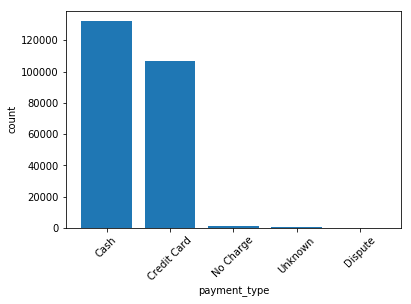

In [104]:
_.bar()

#### 9. What is the difference between weekends and weekdays?

__Expectation__: There will be obvious difference. From the above analysis, we can assume that many people take taxi to work. So during weekends the number of records will drop down significantly.

__Findings__: From the chart we find that there is a periodic pattern. Every Friday reaches a peak.

In [105]:
%%sql
SELECT time.date, round(AVG(trip_total),2),COUNT(trip_total)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
GROUP BY time.date
ORDER BY time.date

 * postgresql://student@/project4
20 rows affected.


date,round,count
2016-01-01 00:00:00,13.41,15746
2016-01-02 00:00:00,14.95,10079
2016-01-03 00:00:00,17.44,9048
2016-01-04 00:00:00,16.85,9547
2016-01-05 00:00:00,15.53,10568
2016-01-06 00:00:00,15.62,11214
2016-01-07 00:00:00,15.95,11832
2016-01-08 00:00:00,14.51,14111
2016-01-09 00:00:00,13.58,11698
2016-01-10 00:00:00,16.49,10165


<BarContainer object of 20 artists>

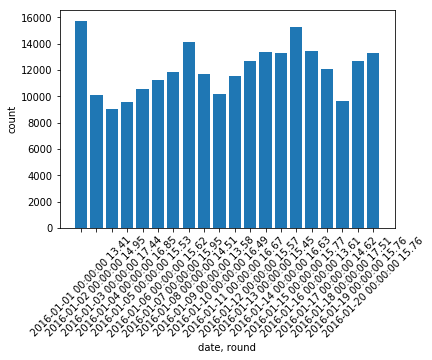

In [106]:
_.bar()

#### 10. What is the relationship between time and pickup location?

__Expectation__: In the morning, people go for work. Thus, we assume that people will take taxi from places which are not developed communities and that there are not many people living near workplaces due to high rent. In the afternoon, on the contrary, people tend to have business trips or leave work. Therefore, we assume that the number of people who take taxi is higher in those CBD areas.

__Findings:__ The top 10 community name are the same ignoring day time and night tame. It is likely that people live in the same community area where they work. 

In [107]:
%%sql
SELECT  location.community_name, COUNT(location.community_name)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
LEFT JOIN location
ON chicago.dropoff_key = location.location_key
WHERE time LIKE '%PM%'
GROUP BY location.community_name
ORDER BY COUNT(location.community_name) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community_name,count
Near North Side,47202
Loop,27638
Near West Side,18291
Lake View,11581
Lincoln Park,11378
West Town,7766
O'Hare,4083
Near South Side,3991
Uptown,2923
Logan Square,2896


In [108]:
%%sql
SELECT  location.community_name, COUNT(location.community_name)
FROM chicago
LEFT JOIN time
ON chicago.time_key = time.time_key
LEFT JOIN location
ON chicago.dropoff_key = location.location_key
WHERE time LIKE '%AM%'
GROUP BY location.community_name
ORDER BY COUNT(location.community_name) DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community_name,count
Near North Side,20942
Loop,19327
Near West Side,7955
Lake View,7276
Lincoln Park,5643
West Town,4892
O'Hare,3427
Uptown,2239
Logan Square,2094
Near South Side,1762


## Bonus - Augment (10 points)

_Sometimes the most value can be gained from one dataset when it is
studied alongside data drawn from other sources.  Identify and
describe at least one additional data source that can complement
your analysis.  Pull this additional data into your chosen environment
and explore at least one more theme you are able to further analyze
that depends upon a combination of data from both sources._

In order to gain more information from the chicago taxi dataset, we was able to found another dataset which contains the weather of 30 countries in North America, from 2012 to 2017. To get what we want, we use csvcut to select `Chicago` column and then use xsv to select only 2016's data, save them into `chicago_weather_2016.csv`

### Import the weather dataset 

In [109]:
!wget https://s3.amazonaws.com/chicagotax/weather_description.csv

--2018-12-10 16:57:11--  https://s3.amazonaws.com/chicagotax/weather_description.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21858089 (21M) [text/csv]
Saving to: ‘weather_description.csv’

weather_description 100%[===================>]  20.84M  39.1MB/s    in 0.5s    

2018-12-10 16:57:12 (39.1 MB/s) - ‘weather_description.csv’ saved [21858089/21858089]



By analyzing we can see there are 45254 rows in this dataset

In [110]:
!wc -l weather_description.csv 

45254 weather_description.csv


In [111]:
!csvcut -n weather_description.csv 

  1: datetime
  2: Vancouver
  3: Portland
  4: San Francisco
  5: Seattle
  6: Los Angeles
  7: San Diego
  8: Las Vegas
  9: Phoenix
 10: Albuquerque
 11: Denver
 12: San Antonio
 13: Dallas
 14: Houston
 15: Kansas City
 16: Minneapolis
 17: Saint Louis
 18: Chicago
 19: Nashville
 20: Indianapolis
 21: Atlanta
 22: Detroit
 23: Jacksonville
 24: Charlotte
 25: Miami
 26: Pittsburgh
 27: Toronto
 28: Philadelphia
 29: New York
 30: Montreal
 31: Boston
 32: Beersheba
 33: Tel Aviv District
 34: Eilat
 35: Haifa
 36: Nahariyya
 37: Jerusalem


In [112]:
!head -500 weather_description.csv  | csvstat

  1. "datetime"

	Type of data:          DateTime
	Contains null values:  False
	Unique values:         499
	Smallest value:        2012-10-01 12:00:00
	Largest value:         2012-10-22 06:00:00
	Most common values:    2012-10-01 12:00:00 (1x)
	                       2012-10-01 13:00:00 (1x)
	                       2012-10-01 14:00:00 (1x)
	                       2012-10-01 15:00:00 (1x)
	                       2012-10-01 16:00:00 (1x)

  2. "Vancouver"

	Type of data:          Text
	Contains null values:  True (excluded from calculations)
	Unique values:         13
	Longest value:         27 characters
	Most common values:    sky is clear (362x)
	                       broken clouds (41x)
	                       mist (39x)
	                       light intensity shower rain (19x)
	                       overcast clouds (14x)

  3. "Portland"

	Type of data:          Text
	Contains null values:  True (excluded from calculations)
	Unique values:         13
	Longest value:         20 ch

We select the datetime and Chicago column and rename the file.

In [113]:
!csvcut -c1,18 weather_description.csv > chicago_weather.csv

In [114]:
!xsv search -s datetime '2016' chicago_weather.csv > chicago_weather_2016.csv

In [115]:
!csvstat chicago_weather_2016.csv

  1. "datetime"

	Type of data:          DateTime
	Contains null values:  False
	Unique values:         8784
	Smallest value:        2016-01-01 00:00:00
	Largest value:         2016-12-31 23:00:00
	Most common values:    2016-01-01 00:00:00 (1x)
	                       2016-01-01 01:00:00 (1x)
	                       2016-01-01 02:00:00 (1x)
	                       2016-01-01 03:00:00 (1x)
	                       2016-01-01 04:00:00 (1x)

  2. "Chicago"

	Type of data:          Text
	Contains null values:  False
	Unique values:         25
	Longest value:         35 characters
	Most common values:    sky is clear (1957x)
	                       broken clouds (1198x)
	                       mist (999x)
	                       overcast clouds (936x)
	                       light rain (872x)

Row count: 8784


### Build the table     
We first build a weather table and import data directly from our csv file, then use this table to left join with the chicago table.

In [116]:
!wget https://s3.amazonaws.com/chicagotax/schema1.png

--2018-12-10 16:57:24--  https://s3.amazonaws.com/chicagotax/schema1.png
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159851 (156K) [image/png]
Saving to: ‘schema1.png’

schema1.png         100%[===================>] 156.10K  --.-KB/s    in 0.005s  

2018-12-10 16:57:24 (28.0 MB/s) - ‘schema1.png’ saved [159851/159851]



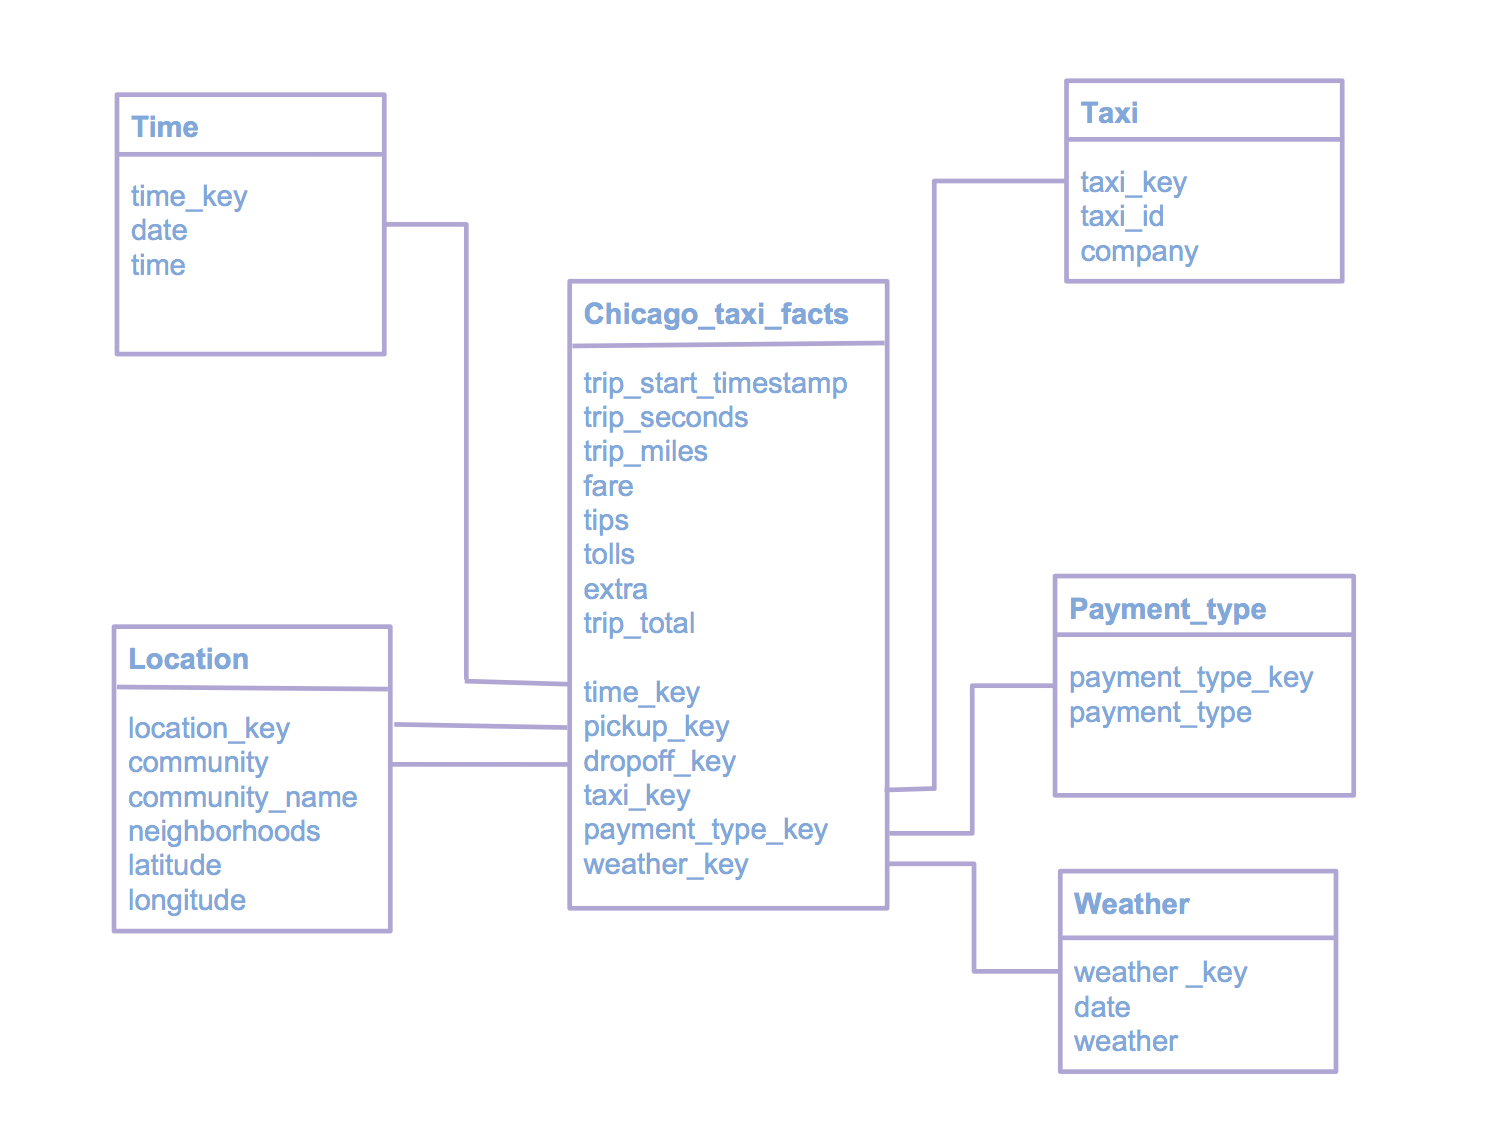

In [117]:
Image(filename = 'schema1.png', width = 800, height = 600)

In [118]:
%%sql 
DROP TABLE IF EXISTS chicago_weather;

CREATE TABLE chicago_weather (
    date TIMESTAMP NOT NULL,
    weather VARCHAR(500) NOT NULL
)

 * postgresql://student@/project4
Done.
Done.


[]

In [119]:
!cp chicago_weather_2016.csv /tmp/chicago_weather_2016.csv

In [120]:
%%sql
COPY chicago_weather FROM '/tmp/chicago_weather_2016.csv'
CSV
HEADER;

 * postgresql://student@/project4
8784 rows affected.


[]

In [121]:
%%sql
SELECT * FROM chicago_weather
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


date,weather
2016-01-01 00:00:00,scattered clouds
2016-01-01 01:00:00,sky is clear
2016-01-01 02:00:00,sky is clear
2016-01-01 03:00:00,scattered clouds
2016-01-01 04:00:00,overcast clouds
2016-01-01 05:00:00,overcast clouds
2016-01-01 06:00:00,broken clouds
2016-01-01 07:00:00,sky is clear
2016-01-01 08:00:00,sky is clear
2016-01-01 09:00:00,sky is clear


In [122]:
%%sql
ALTER TABLE chicago
ADD COLUMN weather VARCHAR(500)

 * postgresql://student@/project4
Done.


[]

In [123]:
%%sql
UPDATE chicago
SET weather = chicago_weather.weather
FROM chicago_weather
WHERE chicago.trip_start_timestamp = chicago_weather.date

 * postgresql://student@/project4
241283 rows affected.


[]

In [124]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


trip_start_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key,weather
2016-01-06 00:00:00,360.0,1.2,6.25,0.0,0.0,0.0,6.25,497,260,174,1458,4,sky is clear
2016-01-13 00:00:00,300.0,1.0,6.0,0.0,0.0,0.0,6.0,1291,52,40,1054,4,sky is clear
2016-01-14 00:00:00,300.0,0.5,5.0,0.0,0.0,0.0,5.0,918,335,181,1143,4,overcast clouds
2016-01-08 00:00:00,480.0,2.1,9.0,0.0,0.0,1.0,10.0,144,147,72,1913,4,light rain
2016-01-14 00:00:00,600.0,1.8,8.75,0.0,0.0,0.0,8.75,14,174,61,1627,4,overcast clouds
2016-01-12 00:00:00,300.0,1.1,6.25,0.0,0.0,0.0,6.25,624,72,72,703,4,overcast clouds
2016-01-08 00:00:00,360.0,0.7,6.0,0.0,0.0,0.0,6.0,1487,40,369,415,4,light rain
2016-01-18 00:00:00,1380.0,0.7,31.0,0.0,0.0,0.0,31.0,1565,76,208,2542,4,sky is clear
2016-01-19 00:00:00,1020.0,3.3,13.0,0.0,0.0,0.0,13.0,296,211,105,1550,4,scattered clouds
2016-01-13 00:00:00,480.0,1.3,7.0,0.0,0.0,1.0,8.0,1434,173,43,565,4,sky is clear


** Weather table**    
Now we have the chicago table with weather. However, since weather is another dimension, we dicide to split it and also timestamp from `chicago` and replace it with `weather_key`. To create a new dimension table, just like what we have done in the previous part, we create an index according to these two columns and then update `chicago` table.

In [125]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


trip_start_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key,weather
2016-01-13 00:00:00,480.0,1.3,7.0,0.0,0.0,1.0,8.0,1434,173,43,565,4,sky is clear
2016-01-20 00:00:00,300.0,1.0,6.0,0.0,0.0,0.0,6.0,1175,390,390,1576,4,broken clouds
2016-01-16 00:00:00,180.0,0.4,4.25,0.0,0.0,0.0,4.25,1051,268,268,1382,4,mist
2016-01-15 00:00:00,420.0,1.1,6.5,0.0,0.0,0.0,6.5,1270,61,227,2426,4,sky is clear
2016-01-05 00:00:00,300.0,0.9,6.0,0.0,0.0,1.0,7.0,948,268,181,1054,4,overcast clouds
2016-01-15 00:00:00,300.0,2.0,8.0,0.0,0.0,1.0,9.0,1081,53,72,414,4,sky is clear
2016-01-08 00:00:00,180.0,0.6,5.0,0.0,0.0,1.0,6.0,1463,181,335,642,4,light rain
2016-01-02 00:00:00,480.0,1.5,6.85,0.0,0.0,1.0,7.85,945,13,210,2506,4,sky is clear
2016-01-13 00:00:00,540.0,0.2,6.5,0.0,0.0,0.0,6.5,1913,204,402,2270,4,sky is clear
2016-01-04 00:00:00,120.0,0.4,4.5,0.0,0.0,0.0,4.5,1251,363,363,1526,4,light snow


**Weather table**

Now we have the chicago table with weather. However, since weather is another dimension, we dicide to split it and also timestamp from `chicago` and replace it with `weather_key`. To create a new dimension table, just like what we have done in the previous part, we create an index according to these two columns and then update `chicago` table.

In [126]:
%%sql
SELECT DISTINCT trip_start_timestamp, weather
FROM chicago

 * postgresql://student@/project4
20 rows affected.


trip_start_timestamp,weather
2016-01-01 00:00:00,scattered clouds
2016-01-02 00:00:00,sky is clear
2016-01-03 00:00:00,sky is clear
2016-01-04 00:00:00,light snow
2016-01-05 00:00:00,overcast clouds
2016-01-06 00:00:00,sky is clear
2016-01-07 00:00:00,light rain
2016-01-08 00:00:00,light rain
2016-01-09 00:00:00,light rain
2016-01-10 00:00:00,mist


In [127]:
%%sql
DROP TABLE IF EXISTS weather;

CREATE TABLE weather (
    weather_key SERIAL PRIMARY KEY,
    date TIMESTAMP NOT NULL,
    weather VARCHAR(500) NOT NULL
)

 * postgresql://student@/project4
Done.
Done.


[]

In [128]:
%%sql
INSERT INTO weather (date, weather)
SELECT DISTINCT trip_start_timestamp, weather
FROM chicago;

 * postgresql://student@/project4
20 rows affected.


[]

In [129]:
%%sql
ALTER TABLE chicago
ADD COLUMN weather_key INTEGER,
ADD CONSTRAINT fk_weather_key
    FOREIGN KEY (weather_key)
    REFERENCES weather (weather_key)

 * postgresql://student@/project4
Done.


[]

In [130]:
%%sql
DROP INDEX IF EXISTS idx_weather;

CREATE INDEX idx_weather ON weather (date, weather);

 * postgresql://student@/project4
Done.
Done.


[]

In [131]:
%%sql
SELECT * FROM weather
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


weather_key,date,weather
1,2016-01-01 00:00:00,scattered clouds
2,2016-01-02 00:00:00,sky is clear
3,2016-01-03 00:00:00,sky is clear
4,2016-01-04 00:00:00,light snow
5,2016-01-05 00:00:00,overcast clouds
6,2016-01-06 00:00:00,sky is clear
7,2016-01-07 00:00:00,light rain
8,2016-01-08 00:00:00,light rain
9,2016-01-09 00:00:00,light rain
10,2016-01-10 00:00:00,mist


In [132]:
%%sql
UPDATE chicago
SET weather_key = weather.weather_key
FROM weather
WHERE chicago.trip_start_timestamp = weather.date 
AND chicago.weather = weather.weather

 * postgresql://student@/project4
241283 rows affected.


[]

In [133]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


trip_start_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key,weather,weather_key
2016-01-13 00:00:00,540.0,0.2,6.5,0.0,0.0,0.0,6.5,1913,204,402,2270,4,sky is clear,13
2016-01-04 00:00:00,120.0,0.4,4.5,0.0,0.0,0.0,4.5,1251,363,363,1526,4,light snow,4
2016-01-20 00:00:00,1140.0,10.7,28.25,0.0,0.0,4.0,32.25,1635,123,204,1789,4,broken clouds,20
2016-01-09 00:00:00,180.0,0.6,4.75,0.0,0.0,0.0,4.75,298,181,335,126,4,light rain,9
2016-01-20 00:00:00,240.0,0.6,5.0,0.0,0.0,0.0,5.0,1534,204,174,831,4,broken clouds,20
2016-01-12 00:00:00,720.0,2.4,10.0,0.0,0.0,0.0,10.0,1267,40,402,898,4,overcast clouds,12
2016-01-06 00:00:00,360.0,0.8,6.0,4.0,0.0,0.0,10.0,233,367,204,2539,5,sky is clear,6
2016-01-20 00:00:00,960.0,0.1,12.0,0.0,0.0,0.0,12.0,1303,120,53,2096,4,broken clouds,20
2016-01-06 00:00:00,720.0,1.9,8.45,0.0,0.0,0.0,8.45,698,204,349,2293,4,sky is clear,6
2016-01-16 00:00:00,420.0,0.7,6.0,0.0,0.0,1.0,7.0,1439,13,181,465,4,mist,16


Drop the original columns from `chicago`

In [134]:
%%sql
ALTER TABLE chicago
DROP COLUMN trip_start_timestamp,
DROP COLUMN weather

 * postgresql://student@/project4
Done.


[]

In [135]:
%%sql
SELECT * FROM chicago
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


trip_seconds,trip_miles,fare,tips,tolls,extra,trip_total,time_key,pickup_key,dropoff_key,taxi_key,payment_type_key,weather_key
420.0,0.7,6.0,0.0,0.0,1.0,7.0,1439,13,181,465,4,16
600.0,0.1,8.25,0.0,0.0,0.0,8.25,1913,204,149,991,4,13
900.0,3.1,12.0,0.0,0.0,0.0,12.0,793,388,335,2459,4,13
360.0,1.1,6.0,0.0,0.0,0.0,6.0,64,181,369,1268,4,20
360.0,0.9,6.0,0.0,0.0,0.0,6.0,37,369,173,2358,4,11
480.0,1.4,7.25,0.0,0.0,0.0,7.25,1408,367,174,126,4,14
1740.0,0.4,24.0,0.0,0.0,0.0,24.0,163,348,174,1719,4,6
240.0,0.5,4.75,0.0,0.0,1.0,5.75,1642,363,363,2405,4,16
720.0,2.8,10.0,0.0,0.0,0.0,10.0,4,174,119,681,4,4
1200.0,1.9,11.25,0.0,0.0,0.0,11.25,1022,260,367,1445,4,12


### Analysis with the new table

We can see that most of time in our dataset, the weather condition is 'sky is clear'. Then we calculate the average price of each weather condition and find there are little difference between them, so it means that in Chicago, the taxi company will not change their price denpends on weather.

In [136]:
%%sql
SELECT *
FROM weather
LIMIT 3

 * postgresql://student@/project4
3 rows affected.


weather_key,date,weather
1,2016-01-01 00:00:00,scattered clouds
2,2016-01-02 00:00:00,sky is clear
3,2016-01-03 00:00:00,sky is clear


In [137]:
%%sql
SELECT  DISTINCT weather, COUNT(weather)
FROM weather
GROUP BY weather

 * postgresql://student@/project4
7 rows affected.


weather,count
broken clouds,1
light snow,1
scattered clouds,4
light rain,3
mist,2
sky is clear,6
overcast clouds,3


<BarContainer object of 7 artists>

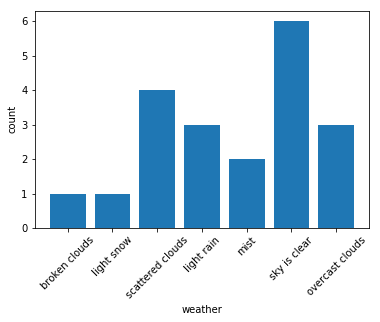

In [138]:
_.bar()

In [139]:
%%sql
SELECT  weather.weather, round(AVG(chicago.fare),2) AS price
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
GROUP BY weather.weather
ORDER BY AVG(chicago.fare) DESC

 * postgresql://student@/project4
7 rows affected.


weather,price
light snow,14.57
overcast clouds,13.66
sky is clear,13.60
broken clouds,13.49
scattered clouds,12.69
mist,12.66
light rain,12.63


<BarContainer object of 7 artists>

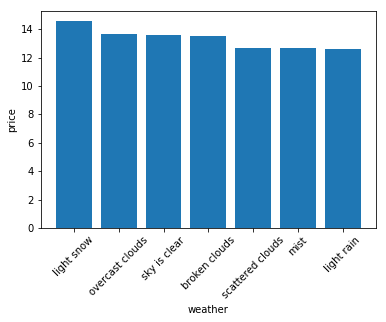

In [140]:
_.bar()

Then we analyze the relationship among duration, trip distance and weather. People tend to ride taxi for more miles during the snow days and least on mist days. We think it is because people don't want to walk during cold weather, and mist days is not that suitable for driving.

In [141]:
%%sql
SELECT  weather.weather,round(AVG(chicago.trip_seconds),2) AS duration, round(AVG(chicago.trip_miles),2) AS miles
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
GROUP BY weather.weather
ORDER BY AVG(chicago.trip_seconds) DESC

 * postgresql://student@/project4
7 rows affected.


weather,duration,miles
overcast clouds,806.93,3.10
broken clouds,801.06,3.05
light snow,771.71,3.57
sky is clear,765.22,3.20
light rain,744.72,2.76
scattered clouds,740.78,2.96
mist,669.70,2.84


**1.Do weather affect people's behaviour on using taxi service?**    
Also, we want to know whether there is any relationship between weather and the number of people who use taxi service. Therefore we count the number of people who use taxi service for each weather.


In [142]:
%%sql
SELECT weather.weather, COUNT(weather.weather) AS count 
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
GROUP BY weather

 * postgresql://student@/project4
7 rows affected.


weather,count
mist,23621
light snow,9547
broken clouds,13266
overcast clouds,36593
light rain,37641
sky is clear,68655
scattered clouds,51960


<BarContainer object of 7 artists>

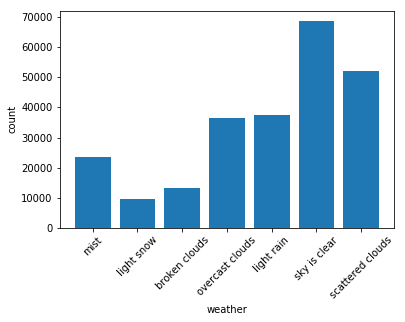

In [143]:
_.bar()

Obviously, we find that when the weather is sunny, more people will choose taxi. On the contrary, few people choose taxi on snowy days. It is likely that during snow days, roads would be covered and cars would be slow down. People may found it is more convenient for them to take public transportation when the weather is bad.

**2.Does weather affect pickup location?**

Although there are many communities in Chicago, we just choose the top 10 communities with most pickup location under different weather for convenience. In this section we use `chicago`, `location` and `weather` table, left join them and select certain type of weather each time.

In [144]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'sky is clear'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
8,22501
32,16354
28,7164
76,4603
6,3995
7,3202
56,1959
24,1889
33,1251
3,1077


<BarContainer object of 10 artists>

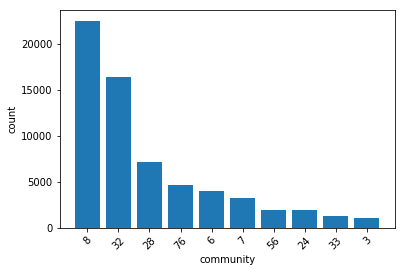

In [145]:
_.bar()

In [146]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'overcast clouds'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
32,11129
8,10962
28,4442
76,2299
6,1509
7,1344
56,890
24,827
3,526
33,474


<BarContainer object of 10 artists>

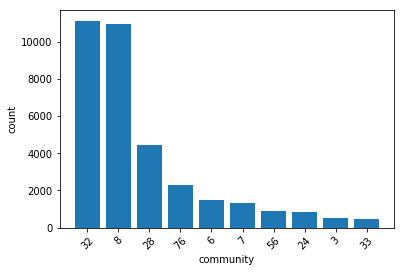

In [147]:
_.bar()

In [148]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'light snow'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
8,2696
32,2379
28,1043
76,919
6,555
7,362
56,358
24,207
3,172
33,132


<BarContainer object of 10 artists>

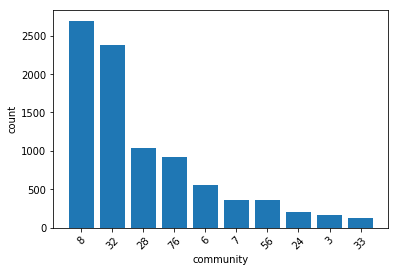

In [149]:
_.bar()

In [150]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'broken clouds'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
32,4196
8,3922
28,1755
76,783
6,498
7,427
56,299
24,292
3,176
33,153


<BarContainer object of 10 artists>

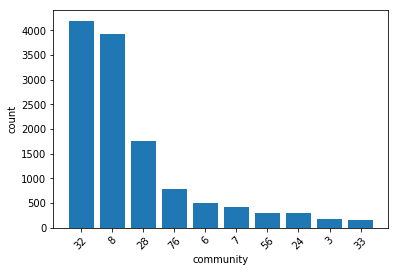

In [151]:
_.bar()

In [152]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'mist'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
8,9164
32,2685
6,2343
7,1991
28,1767
24,1181
76,1098
33,514
3,486
22,452


<BarContainer object of 10 artists>

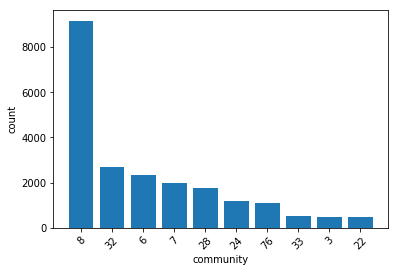

In [153]:
_.bar()

In [154]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'light rain'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
8,12641
32,8805
28,4042
6,2456
7,2153
76,1869
24,1273
56,637
3,595
33,534


<BarContainer object of 10 artists>

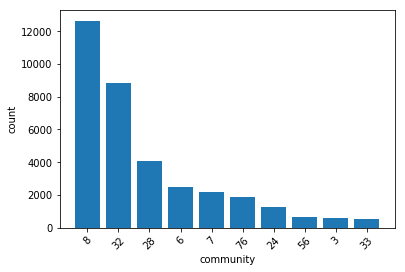

In [155]:
_.bar()

In [156]:
%%sql
SELECT location.community, COUNT(location.community)AS count
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
LEFT JOIN location
ON chicago.pickup_key = location.location_key
WHERE weather.weather = 'scattered clouds'
GROUP BY location.community
ORDER BY count DESC
LIMIT 10

 * postgresql://student@/project4
10 rows affected.


community,count
8,17214
32,10751
28,4727
6,4140
7,3026
76,2731
24,2207
56,1066
3,978
33,951


<BarContainer object of 10 artists>

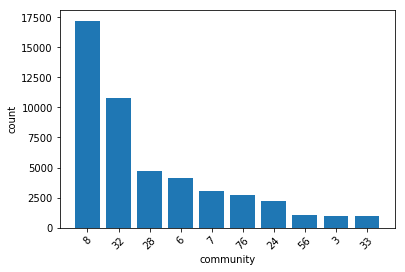

In [157]:
_.bar()

From the 7 bar chart above we can see that no matter what kinds of weather, maybe somethimes the order of them will change slightly, but the top 10 communities stays same. So we can say that whether will not affect people's pickup location.

**3. Are people more willing to give tips on bad weather than on good weather**

In [158]:
%%sql
SELECT weather.weather, round(AVG(chicago.tips),2) AS avg_tips
FROM chicago
LEFT JOIN weather
ON chicago.weather_key = weather.weather_key
GROUP BY weather.weather
ORDER BY avg_tips DESC

 * postgresql://student@/project4
7 rows affected.


weather,avg_tips
broken clouds,1.69
overcast clouds,1.65
sky is clear,1.54
light snow,1.53
light rain,1.39
scattered clouds,1.37
mist,1.32


<BarContainer object of 7 artists>

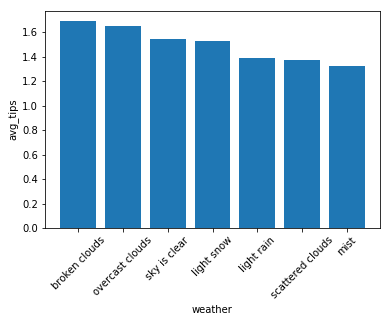

In [159]:
_.bar()

Since the bar chart cannot show us much difference between each weather, we cannot draw such conclusion that people are more willing to give more tips under certain kind of weather.

### Conclusion

In the group project, we chose the dataset about 2016 Chicago  taxi information, clean and prepare the dataset. After we have a basic look at the data structure , we come up with 10 business questions. These questions analyze when people tend to use taxies, which community area is popular destination, how the initial price is calculated and etc.  After using various tools and visualization, we know the behaviour of people when taking taxies, overall information about taxi industry in Chicago and the economic condition of some communities.  

Nowadays, the whole society advocates sharing economy.  This background information can help Uber, a new product of digital society , get into the automotive industry. 

## Some more research about the influence of Uber.

We also tried to figure out how Uber influence the traditional taxi market in Chicago. According to Chicago Dispatcher, Chicago has a combination of significant taxi capacity (50% more cabs per capita than NYC) and incredibly low prices – 2nd lowest in the country.

In Chicago, Uber’s growth is associated with a decline in particular types of complaints about taxis, including broken credit card machines, air conditioning and heating, rudeness, and talking on cell phones. Uber takes a 20% commission from the driver’s earnings for each ride that they complete. 

Taxicabs in Chicago are operated by private companies and licensed by the city. There are about seven thousand licensed cabs operating within the city limits. Uber can provide a less expensive service that merges the renowned quality processes with the power of choice for the consumers.  

The base price of  Uberpool and UberX and Black SUV  is 1.79, 1.79 and 14. Price per minute is  0.20, 0.28 and 0.55. Uber definitely has better price advantage.  
We believe by providing our data analysis about Chicago taxi in 2016, we can suggest Uber to maintain the competitive advantage, allocating the cars to the areas with high demand at rush hours,  optimizing the operation, setting a reasonable pricing strategy to organize the whole transportation system better and create value to the whole community.

## Attestation
Each member has participated in the discussions and has contributed to this project. The details about our contributions have been listed as follows:    

__Jingsi WU:__ 
1. Cleaned the data using trafica (Part1)
2. Wrangled the dataset,created the fact and dimension tables(Part 2)
3. Searched dataset for bonus part, clean the dataset and analyze it with the original one. Responsible for markdown of this part (Part 4)
4. Drew some visualization pictures (All parts)
5. Checked and polished markdown for the whole project.(All parts)
6. Found and prepare the json file used for encoding the masked column.(Part 1)
7. Made presentation slides.

__Jingyi LIU__ 
1. Did the fundamental cleaning the data steps such as encode the masked column and made the data available for analysis.(Part1)
2. Searched and found the original dataset,uploaded all the files to the Amazon S3 buckects.(All parts)
3. Did initial explorations in Part 1 using shell and pipelines.(part 1)
4. Wrangled the dataset,created the fact and dimension tables with Jingsi(Part 2)
5. Did most of the programming jobs for part3 and drew some visualization pictures.
6. Write and polish the markdowns for part1 and part2, checked and polished markdown for part 3.
7. Did some analysis works for the bonus part.
8. Made presentation slides.

__Yidan WANG__  
1. Added some analysis for part 3
2. Drew the pricture for the two schemas.
3. Added some questions about what we need to analyze
4. Added markdown about background information, part3 analysis and conclusion.
5. Made presentation slides.

__Xiaonan ZHAN__ 
1. Wrote part of the markdown，drew the prictures of schem
2. Helped finishing part 3
3. Collect information about the taxi industry and uber for the last part.
4. Made presentation slides.
